#CA 7
## 1. EDA

In [1]:
import pandas as pd
import json
import matplotlib.pyplot as plt
from wordcloud import WordCloud
from collections import Counter
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import string
import nltk
import re

In [2]:
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


True

### 1.1. Load data and change format from jsonl to pandas df

In [3]:
from google.colab import drive
drive.mount('/content/drive')

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

Mounted at /content/drive


In [4]:
train_file_path = '/content/drive/My Drive/imdb/train_imdb.jsonl'
test_file_path = '/content/drive/My Drive/imdb/test_imdb.jsonl'
augment_file_path = '/content/drive/My Drive/imdb/aug_imdb_unlabeled.jsonl'

df_train = load_jsonl(train_file_path)
df_test = load_jsonl(test_file_path)
df_augment = load_jsonl(augment_file_path)

### 1.2. Extracting some basic information

In [5]:
df_train.head(5)

,text,label,embedding
0,fairly good romantic comedy in which i don't t...,1,"[-0.0167805497, -0.0395836979, 0.1233159453, -..."
1,"""dressed to kill"", is one of the best thriller...",1,"[-0.1252697259, 0.1014768854, 0.1718291789, -0..."
2,i'm glad that users (as of this date) who like...,1,"[0.1312361956, 0.0294876788, 0.2328549027, -0...."
3,needed an excuse to get out of the house while...,0,"[0.1387384981, 0.0460377187, 0.3447172046, -0...."
4,john candy's performance in once upon a crime ...,1,"[0.1606466323, -0.1768193543, 0.3563380837, -0..."


In [6]:
print(f"Number of training reviews: {len(df_train)}")
print(f"Number of test reviews: {len(df_test)}")
print("Training Sentiment Distribution:\n", df_train['label'].value_counts())
print("Test Sentiment Distribution:\n", df_test['label'].value_counts())

Number of training reviews: 150
Number of test reviews: 150
Training Sentiment Distribution:
 label
1    83
0    67
Name: count, dtype: int64
Test Sentiment Distribution:
 label
0    78
1    72
Name: count, dtype: int64


In [7]:
average_length_train = df_train['text'].apply(len).mean()
average_length_test = df_test['text'].apply(len).mean()
average_length_augment = df_augment['text'].apply(len).mean()
print("\nAverage Length of Reviews:")
print("Train Set:", average_length_train)
print("Test Set:", average_length_test)
print("Augmented Set:", average_length_augment)


Average Length of Reviews:
Train Set: 503.8066666666667
Test Set: 545.2466666666667
Augmented Set: 532.913214990138


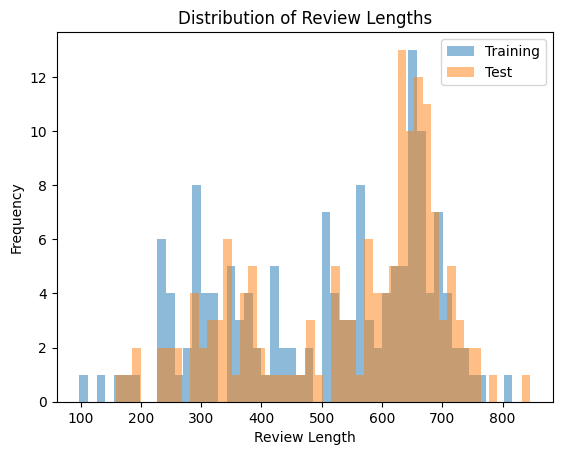

In [8]:
df_train['review_length'] = df_train['text'].apply(len)
df_test['review_length'] = df_test['text'].apply(len)
plt.hist(df_train['review_length'], bins=50, alpha=0.5, label='Training')
plt.hist(df_test['review_length'], bins=50, alpha=0.5, label='Test')
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.legend()
plt.title('Distribution of Review Lengths')
plt.show()

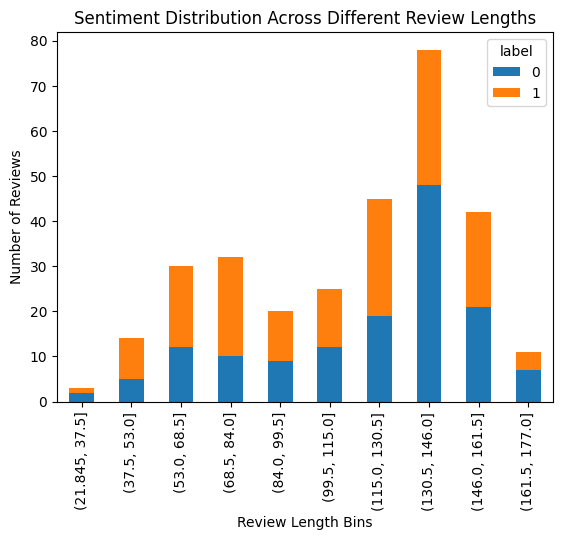

In [9]:
def analyze_sentiment_distribution(df):
    df['review_length'] = df['text'].apply(lambda x: len(word_tokenize(x)))
    df['review_length_bins'] = pd.cut(df['review_length'], bins=10)
    sentiment_distribution = df.groupby(['review_length_bins', 'label']).size().unstack(fill_value=0)
    sentiment_distribution.plot(kind='bar', stacked=True)
    plt.title("Sentiment Distribution Across Different Review Lengths")
    plt.xlabel("Review Length Bins")
    plt.ylabel("Number of Reviews")
    plt.show()

df_combined = pd.concat([df_train, df_test], ignore_index=True)
analyze_sentiment_distribution(df_combined)

### 1.3. preprocess the data
In this section we performed these action on the dataset to prepare it for the next steps: making all the words lowercase, removing the html tag \br, removing punctuations, tokenizing the words and lemmatizing them.

In [10]:
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'<br\s*/?>', ' ', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    tokens = word_tokenize(text)

    tokens = [word for word in tokens if word.lower() not in stopwords.words('english')]

    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]

    return ' '.join(tokens)

df_combined['clean_review'] = df_combined['text'].apply(preprocess_text)

### 1.4. Top 10 postive and negative words

In [11]:
def extract_keywords(df):
    stop_words = list(set(stopwords.words('english')))
    tfidf_vectorizer = TfidfVectorizer(stop_words=stop_words)
    tfidf_matrix = tfidf_vectorizer.fit_transform(df['clean_review'])
    feature_names = tfidf_vectorizer.get_feature_names_out()
    df_tfidf = pd.DataFrame(tfidf_matrix.toarray(), columns=feature_names)
    positive_keywords = df_tfidf[df['label'] == 1].mean().sort_values(ascending=False)[:10]
    negative_keywords = df_tfidf[df['label'] == 0].mean().sort_values(ascending=False)[:10]
    return positive_keywords, negative_keywords

positive_keywords, negative_keywords = extract_keywords(df_combined)
print("Top 10 positive keywords:")
print(positive_keywords)
print("Top 10 negative keywords:")
print(negative_keywords)

Top 10 positive keywords:
movie    0.057895
film     0.049228
good     0.030961
one      0.030649
great    0.025424
love     0.023593
see      0.021998
story    0.021879
best     0.020770
like     0.020575
dtype: float64
Top 10 negative keywords:
movie     0.061918
film      0.040754
even      0.027201
bad       0.026477
good      0.025911
one       0.025675
like      0.025407
dont      0.023133
really    0.022837
worst     0.021167
dtype: float64


### 1.5. Word cloud

Positive Reviews Word Cloud


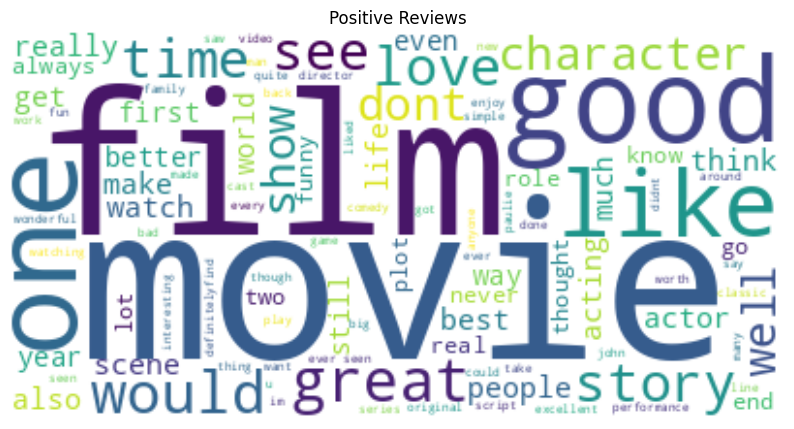

Negative Reviews Word Cloud


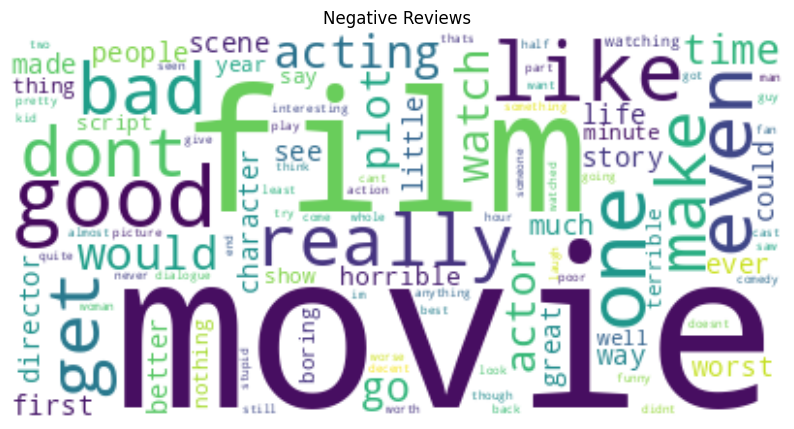

In [12]:
def generate_wordcloud(text, title):
    wordcloud = WordCloud(stopwords=stopwords.words('english'), background_color='white', max_words=100).generate(text)
    plt.figure(figsize=(10, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

positive_reviews = ' '.join(df_combined[df_combined['label'] == 1]['clean_review'])
negative_reviews = ' '.join(df_combined[df_combined['label'] == 0]['clean_review'])

print("Positive Reviews Word Cloud")
generate_wordcloud(positive_reviews, "Positive Reviews")

print("Negative Reviews Word Cloud")
generate_wordcloud(negative_reviews, "Negative Reviews")

### N-grams
N-grams are contiguous sequences of n items from a given text or speech. In the context of text processing, these items are typically words.Consider a sentiment analysis task. The phrases "not good" and "very good" provide different sentiments, which can be captured by bigrams. Analyzing the frequency and context of these bigrams in positive and negative reviews helps improve the performance of sentiment classification models.

By using N-grams, we can better understand the context and common patterns within the text, making them a powerful tool in NLP and text analysis.

In [13]:
def get_ngrams(text, n=2):
    tokens = word_tokenize(text)
    tokens = [token for token in tokens if token.isalpha() and token not in stopwords.words('english')]
    ngrams = zip(*[tokens[i:] for i in range(n)])
    return [' '.join(ngram) for ngram in ngrams]

positive_bigrams_combined = Counter(get_ngrams(positive_reviews, 2)).most_common(20)
negative_bigrams_combined = Counter(get_ngrams(negative_reviews, 2)).most_common(20)

print("Top 20 Bigrams in Positive Reviews:")
print(positive_bigrams_combined)

print("Top 20 Bigrams in Negative Reviews:")
print(negative_bigrams_combined)

Top 20 Bigrams in Positive Reviews:
[('ever seen', 11), ('puppet master', 9), ('ive ever', 8), ('one best', 8), ('must see', 7), ('see movie', 6), ('movie ive', 6), ('ever made', 5), ('tell story', 5), ('saw movie', 5), ('great movie', 5), ('movie great', 5), ('best movie', 5), ('special effect', 5), ('low budget', 4), ('enjoy movie', 4), ('highly recommend', 4), ('thought movie', 4), ('great actor', 4), ('im sure', 4)]
Top 20 Bigrams in Negative Reviews:
[('film ever', 9), ('waste time', 8), ('want see', 8), ('special effect', 7), ('one worst', 7), ('worst movie', 7), ('worst film', 6), ('movie even', 5), ('dont watch', 5), ('cant believe', 5), ('saw movie', 5), ('dont waste', 5), ('bad movie', 5), ('movie would', 5), ('watch movie', 5), ('whole movie', 5), ('ever seen', 5), ('good movie', 5), ('see movie', 4), ('movie like', 4)]


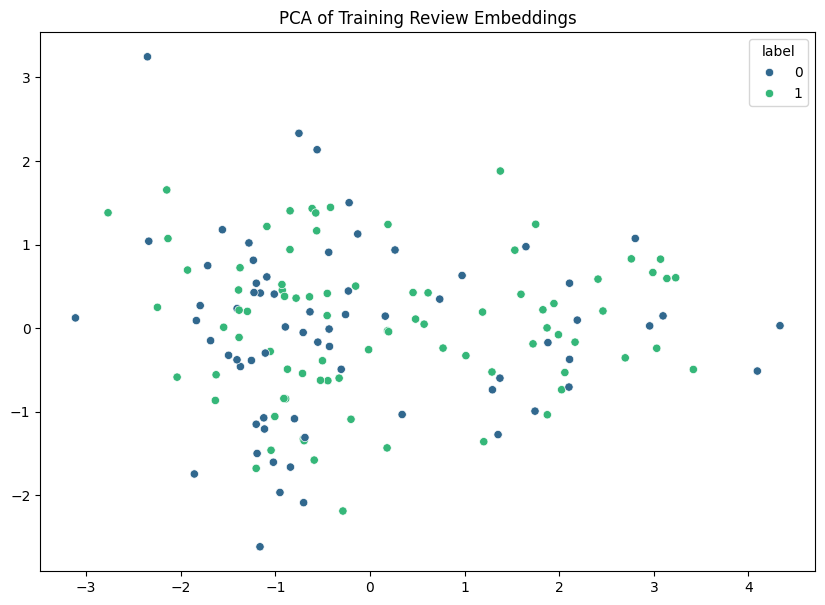

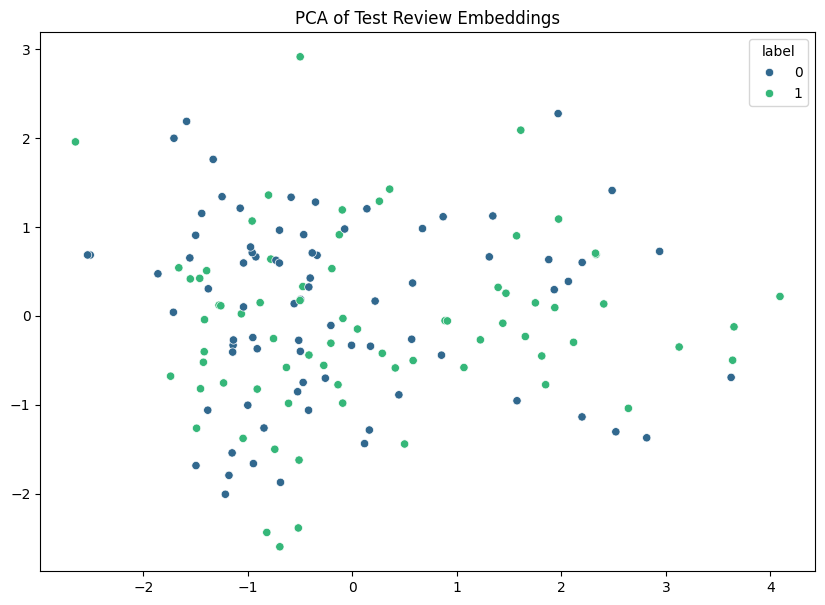

In [14]:
def plot_embeddings(embeddings, labels, title):
    pca = PCA(n_components=2)
    reduced_embeddings = pca.fit_transform(embeddings)
    plt.figure(figsize=(10, 7))
    sns.scatterplot(x=reduced_embeddings[:,0], y=reduced_embeddings[:,1], hue=labels, palette='viridis')
    plt.title(title)
    plt.show()

plot_embeddings(df_train['embedding'].tolist(), df_train['label'], 'PCA of Training Review Embeddings')
plot_embeddings(df_test['embedding'].tolist(), df_test['label'], 'PCA of Test Review Embeddings')

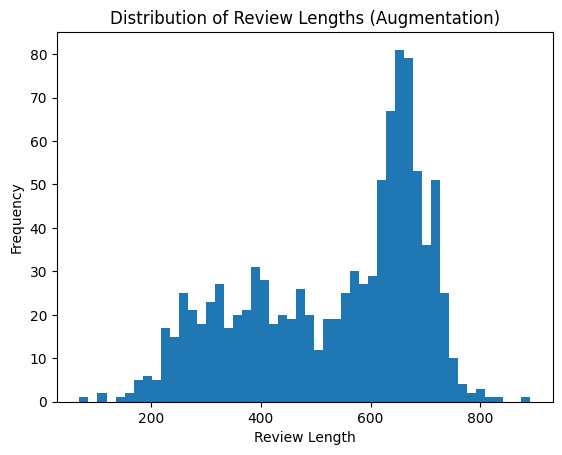

In [15]:
df_augment['review_length'] = df_augment['text'].apply(len)
plt.hist(df_augment['review_length'], bins=50)
plt.xlabel('Review Length')
plt.ylabel('Frequency')
plt.title('Distribution of Review Lengths (Augmentation)')
plt.show()

## 2. Feature Engeineering
Extracting features from text data is a crucial step in natural language processing (NLP) and machine learning. Here are some common methods for feature extraction along with brief explanations:
1. Bag of Words (BoW)

  This method represents text as a collection (bag) of its words, disregarding grammar and word order but keeping multiplicity.
  Each unique word in the corpus is assigned a unique integer ID.
  The text is represented as a vector of word frequencies or binary indicators (presence/absence)
2. Term Frequency-Inverse Document Frequency (TF-IDF)

  Extends the Bag of Words model by scaling down the frequency of words that occur frequently across documents.
  Term Frequency (TF): Number of times a word appears in a document.
  Inverse Document Frequency (IDF): Logarithmically scaled inverse fraction of the documents that contain the word.
3. Word Embeddings (Word2Vec, GloVe, FastText)

  These are dense vector representations of words, capturing semantic meaning.
  Words with similar meanings have similar vectors.
  Pre-trained models (e.g., Word2Vec, GloVe) can be used for this purpose.
4. Doc2Vec

   Extends the Word2Vec model to generate vector representations for entire documents.
   Useful for tasks requiring document-level understanding.
5. N-grams

  Considers sequences of n words (n-grams) instead of single words.
  Captures some context of the words by considering contiguous sequences of tokens.
6. Latent Semantic Analysis (LSA)

  A technique that uses Singular Value Decomposition (SVD) to reduce the dimensionality of the BoW/TF-IDF representation and capture latent semantic structures.
  Helps in identifying patterns in the relationships between terms and concepts.
7. TextRank and Similar Graph-Based Models

  Graph-based ranking algorithms (like TextRank) used for keyword extraction and summarization.
  Words or sentences are nodes in a graph, with edges representing relationships (e.g., co-occurrence).

## 3. Semi-Supervised
### 3.1. Using Traditional Methods (Label Propagation)
Label propagation is a semi-supervised learning technique that can be useful when we have a small amount of labeled data and a large amount of unlabeled data. It leverages the similarity between data points to propagate labels from labeled to unlabeled data. There are several traditional methods for label propagation, including graph-based methods and clustering techniques like KMeans.

```
# This is formatted as code
```



In [16]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV


# Extract features and labels
X_train = np.array(df_train['embedding'].tolist())
y_train = np.array(df_train['label'].tolist())
X_augment = np.array(df_augment['embedding'].tolist())
X_test = np.array(df_test['embedding'].tolist())
y_test = np.array(df_test['label'].tolist())

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_augment = scaler.transform(X_augment)
X_test = scaler.transform(X_test)

# Combine features for clustering
X_combined = np.vstack((X_train, X_augment))

# Hyperparameter tuning for KMeans
kmeans_params = {'n_clusters': range(2, 10)}
kmeans = KMeans(random_state=42)
grid_search = GridSearchCV(kmeans, kmeans_params, cv=5, n_jobs=-1)
grid_search.fit(X_train)
best_kmeans = grid_search.best_estimator_

# Apply KMeans clustering
best_kmeans.fit(X_combined)

# Get cluster labels for the combined data
cluster_labels = best_kmeans.labels_

# Create a dictionary to store majority label for each cluster
cluster_majority_label = {}

for cluster in range(best_kmeans.n_clusters):
    indices = np.where(cluster_labels[:len(X_train)] == cluster)[0]
    cluster_labels_train = y_train[indices]
    if len(cluster_labels_train) > 0:
        majority_label = np.bincount(cluster_labels_train).argmax()
        cluster_majority_label[cluster] = majority_label

# Propagate labels to the augment data
propagated_labels = []

for i in range(len(X_augment)):
    cluster = best_kmeans.predict([X_augment[i]])[0]
    propagated_labels.append(cluster_majority_label[cluster])

# Combine original labels and propagated labels
X_combined_final = np.vstack((X_train, X_augment))
y_combined_final = np.concatenate((y_train, propagated_labels))

# Train a model
# Try Logistic Regression with hyperparameter tuning
param_grid = {'C': [0.1, 1, 10, 100]}
model = LogisticRegression(random_state=42, max_iter=10000)
grid_search = GridSearchCV(model, param_grid, cv=5, n_jobs=-1)
grid_search.fit(X_combined_final, y_combined_final)
best_model = grid_search.best_estimator_

# Evaluate the model
y_pred = best_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')


/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Accuracy: 0.6200


### 3.2. Using LLMs


Methods of Applying LLMs for Classification

  - Zero-shot Classification
  - Few-shot Classification
  - Fine-tuning for Classification

1. Zero-shot Classification

Description:
Zero-shot classification involves using an LLM to classify text into categories it has never seen before, without any task-specific training. The model utilizes its pre-existing knowledge to infer the correct labels based on the context provided.

Application:

  Unlabeled Data: When there is no labeled data available for training.
  Rapid Prototyping: For quick initial classification to understand data distribution or get preliminary insights.
  Dynamic Label Sets: When labels frequently change or are dynamically defined.

Advantages:

  No need for labeled training data.
  Flexible and can adapt to new categories on the fly.

Disadvantages:

  Generally less accurate than fine-tuned models.
  Performance heavily depends on the quality of candidate labels.

2. Few-shot Classification

Description:
Few-shot classification involves providing the LLM with a few examples of each class through carefully designed prompts to help the model understand the task before making predictions.

Application:

   Limited Labeled Data: When only a small amount of labeled data is available.
  Ad-hoc Tasks: For tasks that require immediate setup without extensive training.
   Custom Labels: When dealing with highly specific or niche labels that are not well-represented in the model’s pre-training data.

Advantages:

   Requires minimal labeled data.
  Can leverage the contextual understanding of LLMs effectively.

Disadvantages:

  More complex to implement than zero-shot.
  Results can vary based on the quality of the examples and prompt construction.

3. Fine-tuning for Classification

Description:
Fine-tuning involves taking a pre-trained LLM and training it further on a labeled dataset specific to the classification task. This method requires more computational resources and time but usually results in higher accuracy.

Application:

   Sufficient Labeled Data: When there is a substantial amount of labeled data available.
  High Precision Required: For tasks where accuracy is critical.
  Specific Domain: When the classification task is in a specialized domain that benefits from domain-specific fine-tuning.

Advantages:

  High accuracy and performance.
  Tailored specifically to the task and data at hand.

Disadvantages:

  Requires significant computational resources.
  Needs a sizable labeled dataset.
  Longer setup and training time.

In [17]:
!pip install -U transformers
!pip install -U accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 309.4/309.4 kB 6.5 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [18]:
train_file_path = '/content/drive/My Drive/imdb/train_imdb.jsonl'
test_file_path = '/content/drive/My Drive/imdb/test_imdb.jsonl'
augment_file_path = '/content/drive/My Drive/imdb/aug_imdb_unlabeled.jsonl'

def load_jsonl(file_path):
    data = []
    with open(file_path, 'r') as file:
        for line in file:
            data.append(json.loads(line))
    return pd.DataFrame(data)

df_train = load_jsonl(train_file_path)
df_test = load_jsonl(test_file_path)
df_augment = load_jsonl(augment_file_path)

In [19]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer

MODEL_ARGS = {
    'Name': 'microsoft/Phi-3-mini-128k-instruct',
    'DType': torch.bfloat16
}

def load_model(model_args):
    device = "cuda" if torch.cuda.is_available() else "cpu"

    model = AutoModelForCausalLM.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
        torch_dtype=model_args['DType'],
        low_cpu_mem_usage=True,
        device_map={"": device},
    )
    tokenizer = AutoTokenizer.from_pretrained(
        model_args['Name'],
        trust_remote_code=True,
    )

    return model, tokenizer

model, tokenizer = load_model(MODEL_ARGS)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/3.38k [00:00<?, ?B/s]

configuration_phi3.py:   0%|          | 0.00/10.4k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- configuration_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modeling_phi3.py:   0%|          | 0.00/73.8k [00:00<?, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/microsoft/Phi-3-mini-128k-instruct:
- modeling_phi3.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors.index.json:   0%|          | 0.00/16.3k [00:00<?, ?B/s]

model-00001-of-00002.safetensors:   0%|          | 0.00/4.97G [00:00<?, ?B/s]

model-00002-of-00002.safetensors:   0%|          | 0.00/2.67G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/172 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/3.17k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.84M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/293 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/568 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [20]:
def generate_samples(df, n):
    df_label_1 = df[df['label'] == 1].sample(n=n, random_state=1)
    df_label_0 = df[df['label'] == 0].sample(n=n, random_state=1)

    sampled_df = pd.concat([df_label_1, df_label_0]).sample(frac=1, random_state=1).reset_index(drop=True)

    output = ""
    for i, row in sampled_df.iterrows():
        output += f"Example {i + 1}:\n"
        output += f"Review: {row['text']}\n"
        output += f"Sentiment: {'positive' if row['label'] == 1 else 'negative'}\n\n"

    return output

formatted_string = generate_samples(df_train, 2)

In [21]:
formatted_string

'Example 1:\nReview: this movie got off to an interesting start. down the road however, the story gets convoluted with a poor illustration of ancient black magic rituals. the male lead was very good , even though he gets the worst end of the stick in the climax. in comparison, this is "boomerang" meets "extremities".\nSentiment: negative\n\nExample 2:\nReview: this was a "cute" movie at first, then then got too sappy and featured mediocre songs, at best.<br /><br />there is too much king james english spoken with is not only annoying in today\'s world but not always easy to interpret. can you imagine young people of today trying to listen to this film? forget it.<br /><br />bing crosby has some good lines in here and is likable as "hank martin." rhonda fleming ("alisande la carteloise") was, too, in addition to her good looks and beautiful, long red hair. <br /><br />it\'s a nice movie with a feel-good ending, and i can\'t knock that. maybe this is worthy of a rental, for historical sa

In [22]:
import torch
from transformers import AutoModelForCausalLM, AutoTokenizer
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from google.colab import files
from tqdm import tqdm

def classify_sentiment(model, tokenizer, review, device):
    model.eval()
    with torch.no_grad():
        prompt = (
            f"{formatted_string}\n"
            "What is the sentiment of review? is it positive or negative?\n"
            f"Review: {review}\n"
            "Sentiment:"
        )
        inputs = tokenizer.encode(prompt, return_tensors="pt").to(device)
        outputs = model.generate(
                    inputs,
                    max_new_tokens=10,
                    do_sample=False,
                    temperature=0.5
                )
        sentiment = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return sentiment

def interpret_sentiment(sentiment):
    last_classification_pos = sentiment.rfind("Sentiment:")
    if last_classification_pos != -1:
        classification_text = sentiment[last_classification_pos + len("Sentiment:"):].strip()
        first_word = classification_text.split()[0].lower()
        if "positive" in first_word:
            return 1
        elif "negative" in first_word:
            return 0
    return None


def classify_and_label(df):
    sentiments = []
    for review in tqdm(df['text'], desc="Classifying reviews"):
        sentiment = classify_sentiment(model, tokenizer, review, model.device)
        label = interpret_sentiment(sentiment)
        sentiments.append(label)
        print(label)
    df['predicted_label'] = sentiments
    return df


def plot_label_distribution(df):
    class_counts = df['predicted_label'].value_counts()
    class_labels = class_counts.index
    class_values = class_counts.values

    sns.barplot(x=class_labels, y=class_values, palette='viridis')
    plt.title('Distribution of Sentiment Labels')
    plt.xlabel('Sentiment Label')
    plt.ylabel('Count')
    plt.xticks(ticks=[0, 1], labels=['Negative', 'Positive'])
    plt.show()

Classifying reviews:   0%|          | 0/1014 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/transformers/generation/configuration_utils.py:515: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.5` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
Classifying reviews:   0%|          | 1/1014 [00:05<1:36:12,  5.70s/it]

1


Classifying reviews:   0%|          | 2/1014 [00:09<1:15:45,  4.49s/it]

0


Classifying reviews:   0%|          | 3/1014 [00:13<1:09:16,  4.11s/it]

1


Classifying reviews:   0%|          | 4/1014 [00:17<1:09:15,  4.11s/it]

1


Classifying reviews:   0%|          | 5/1014 [00:21<1:11:57,  4.28s/it]

0


Classifying reviews:   1%|          | 6/1014 [00:25<1:10:36,  4.20s/it]

0


Classifying reviews:   1%|          | 7/1014 [00:29<1:08:21,  4.07s/it]

0


Classifying reviews:   1%|          | 8/1014 [00:34<1:10:51,  4.23s/it]

1


Classifying reviews:   1%|          | 9/1014 [00:38<1:09:32,  4.15s/it]

1


Classifying reviews:   1%|          | 10/1014 [00:41<1:06:33,  3.98s/it]

1


Classifying reviews:   1%|          | 11/1014 [00:45<1:04:32,  3.86s/it]

1


Classifying reviews:   1%|          | 12/1014 [00:49<1:04:10,  3.84s/it]

1


Classifying reviews:   1%|▏         | 13/1014 [00:53<1:06:02,  3.96s/it]

0


Classifying reviews:   1%|▏         | 14/1014 [00:56<1:01:53,  3.71s/it]

0


Classifying reviews:   1%|▏         | 15/1014 [00:59<58:53,  3.54s/it]  

0


Classifying reviews:   2%|▏         | 16/1014 [01:02<57:39,  3.47s/it]

1


Classifying reviews:   2%|▏         | 17/1014 [01:06<56:26,  3.40s/it]

1


Classifying reviews:   2%|▏         | 18/1014 [01:09<56:11,  3.39s/it]

0


Classifying reviews:   2%|▏         | 19/1014 [01:12<56:12,  3.39s/it]

1


Classifying reviews:   2%|▏         | 20/1014 [01:16<55:05,  3.33s/it]

1


Classifying reviews:   2%|▏         | 21/1014 [01:19<56:51,  3.44s/it]

0


Classifying reviews:   2%|▏         | 22/1014 [01:23<57:49,  3.50s/it]

0


Classifying reviews:   2%|▏         | 23/1014 [01:26<57:56,  3.51s/it]

0


Classifying reviews:   2%|▏         | 24/1014 [01:30<56:18,  3.41s/it]

1


Classifying reviews:   2%|▏         | 25/1014 [01:33<55:54,  3.39s/it]

0


Classifying reviews:   3%|▎         | 26/1014 [01:36<56:02,  3.40s/it]

1


Classifying reviews:   3%|▎         | 27/1014 [01:40<57:03,  3.47s/it]

0


Classifying reviews:   3%|▎         | 28/1014 [01:43<55:34,  3.38s/it]

1


Classifying reviews:   3%|▎         | 29/1014 [01:46<54:49,  3.34s/it]

0


Classifying reviews:   3%|▎         | 30/1014 [01:50<54:48,  3.34s/it]

0


Classifying reviews:   3%|▎         | 31/1014 [01:53<54:59,  3.36s/it]

0


Classifying reviews:   3%|▎         | 32/1014 [01:57<56:14,  3.44s/it]

1


Classifying reviews:   3%|▎         | 33/1014 [02:00<55:15,  3.38s/it]

1


Classifying reviews:   3%|▎         | 34/1014 [02:04<55:57,  3.43s/it]

0


Classifying reviews:   3%|▎         | 35/1014 [02:07<57:57,  3.55s/it]

0


Classifying reviews:   4%|▎         | 36/1014 [02:11<56:29,  3.47s/it]

0


Classifying reviews:   4%|▎         | 37/1014 [02:14<56:32,  3.47s/it]

1


Classifying reviews:   4%|▎         | 38/1014 [02:19<1:02:14,  3.83s/it]

0


Classifying reviews:   4%|▍         | 39/1014 [02:22<1:00:31,  3.72s/it]

0


Classifying reviews:   4%|▍         | 40/1014 [02:26<1:00:28,  3.72s/it]

1


Classifying reviews:   4%|▍         | 41/1014 [02:30<1:00:09,  3.71s/it]

0


Classifying reviews:   4%|▍         | 42/1014 [02:33<59:36,  3.68s/it]  

0


Classifying reviews:   4%|▍         | 43/1014 [02:37<57:33,  3.56s/it]

0


Classifying reviews:   4%|▍         | 44/1014 [02:40<58:08,  3.60s/it]

0


Classifying reviews:   4%|▍         | 45/1014 [02:44<57:47,  3.58s/it]

1


Classifying reviews:   5%|▍         | 46/1014 [02:48<58:59,  3.66s/it]

0


Classifying reviews:   5%|▍         | 47/1014 [02:51<58:22,  3.62s/it]

1


Classifying reviews:   5%|▍         | 48/1014 [02:55<58:02,  3.61s/it]

0


Classifying reviews:   5%|▍         | 49/1014 [02:58<56:32,  3.52s/it]

0


Classifying reviews:   5%|▍         | 50/1014 [03:02<57:11,  3.56s/it]

1


Classifying reviews:   5%|▌         | 51/1014 [03:05<56:03,  3.49s/it]

1


Classifying reviews:   5%|▌         | 52/1014 [03:09<56:25,  3.52s/it]

0


Classifying reviews:   5%|▌         | 53/1014 [03:12<55:27,  3.46s/it]

1


Classifying reviews:   5%|▌         | 54/1014 [03:16<57:18,  3.58s/it]

0


Classifying reviews:   5%|▌         | 55/1014 [03:19<57:01,  3.57s/it]

1


Classifying reviews:   6%|▌         | 56/1014 [03:23<56:56,  3.57s/it]

0


Classifying reviews:   6%|▌         | 57/1014 [03:27<56:56,  3.57s/it]

0


Classifying reviews:   6%|▌         | 58/1014 [03:30<56:16,  3.53s/it]

0


Classifying reviews:   6%|▌         | 59/1014 [03:33<55:22,  3.48s/it]

1


Classifying reviews:   6%|▌         | 60/1014 [03:37<54:43,  3.44s/it]

1


Classifying reviews:   6%|▌         | 61/1014 [03:40<55:27,  3.49s/it]

1


Classifying reviews:   6%|▌         | 62/1014 [03:44<57:15,  3.61s/it]

1


Classifying reviews:   6%|▌         | 63/1014 [03:48<56:02,  3.54s/it]

0


Classifying reviews:   6%|▋         | 64/1014 [03:51<56:21,  3.56s/it]

1


Classifying reviews:   6%|▋         | 65/1014 [03:55<57:31,  3.64s/it]

1


Classifying reviews:   7%|▋         | 66/1014 [03:58<56:43,  3.59s/it]

0


Classifying reviews:   7%|▋         | 67/1014 [04:02<57:02,  3.61s/it]

1


Classifying reviews:   7%|▋         | 68/1014 [04:06<56:56,  3.61s/it]

1


Classifying reviews:   7%|▋         | 69/1014 [04:09<57:14,  3.63s/it]

1


Classifying reviews:   7%|▋         | 70/1014 [04:13<56:51,  3.61s/it]

0


Classifying reviews:   7%|▋         | 71/1014 [04:17<57:31,  3.66s/it]

0


Classifying reviews:   7%|▋         | 72/1014 [04:20<57:54,  3.69s/it]

0


Classifying reviews:   7%|▋         | 73/1014 [04:24<58:16,  3.72s/it]

0


Classifying reviews:   7%|▋         | 74/1014 [04:28<58:17,  3.72s/it]

1


Classifying reviews:   7%|▋         | 75/1014 [04:32<57:46,  3.69s/it]

0


Classifying reviews:   7%|▋         | 76/1014 [04:35<58:31,  3.74s/it]

1


Classifying reviews:   8%|▊         | 77/1014 [04:40<59:49,  3.83s/it]

1


Classifying reviews:   8%|▊         | 78/1014 [04:43<59:53,  3.84s/it]

0


Classifying reviews:   8%|▊         | 79/1014 [04:47<59:51,  3.84s/it]

0


Classifying reviews:   8%|▊         | 80/1014 [04:51<58:22,  3.75s/it]

1


Classifying reviews:   8%|▊         | 81/1014 [04:55<1:00:04,  3.86s/it]

1


Classifying reviews:   8%|▊         | 82/1014 [04:58<58:23,  3.76s/it]  

0


Classifying reviews:   8%|▊         | 83/1014 [05:02<59:21,  3.83s/it]

1


Classifying reviews:   8%|▊         | 84/1014 [05:06<59:57,  3.87s/it]

1


Classifying reviews:   8%|▊         | 85/1014 [05:10<59:34,  3.85s/it]

1


Classifying reviews:   8%|▊         | 86/1014 [05:14<57:41,  3.73s/it]

None


Classifying reviews:   9%|▊         | 87/1014 [05:17<56:20,  3.65s/it]

1


Classifying reviews:   9%|▊         | 88/1014 [05:21<56:18,  3.65s/it]

1


Classifying reviews:   9%|▉         | 89/1014 [05:25<58:13,  3.78s/it]

0


Classifying reviews:   9%|▉         | 90/1014 [05:28<57:40,  3.74s/it]

0


Classifying reviews:   9%|▉         | 91/1014 [05:32<56:29,  3.67s/it]

0


Classifying reviews:   9%|▉         | 92/1014 [05:36<58:00,  3.78s/it]

1


Classifying reviews:   9%|▉         | 93/1014 [05:40<57:48,  3.77s/it]

1


Classifying reviews:   9%|▉         | 94/1014 [05:43<57:43,  3.76s/it]

1


Classifying reviews:   9%|▉         | 95/1014 [05:47<56:29,  3.69s/it]

1


Classifying reviews:   9%|▉         | 96/1014 [05:51<58:17,  3.81s/it]

0


Classifying reviews:  10%|▉         | 97/1014 [05:55<58:45,  3.84s/it]

0


Classifying reviews:  10%|▉         | 98/1014 [05:59<58:34,  3.84s/it]

1


Classifying reviews:  10%|▉         | 99/1014 [06:03<58:47,  3.86s/it]

1


Classifying reviews:  10%|▉         | 100/1014 [06:07<59:00,  3.87s/it]

1


Classifying reviews:  10%|▉         | 101/1014 [06:11<59:20,  3.90s/it]

0


Classifying reviews:  10%|█         | 102/1014 [06:15<59:34,  3.92s/it]

0


Classifying reviews:  10%|█         | 103/1014 [06:18<58:51,  3.88s/it]

0


Classifying reviews:  10%|█         | 104/1014 [06:22<58:46,  3.88s/it]

0


Classifying reviews:  10%|█         | 105/1014 [06:26<58:17,  3.85s/it]

1


Classifying reviews:  10%|█         | 106/1014 [06:30<57:37,  3.81s/it]

0


Classifying reviews:  11%|█         | 107/1014 [06:33<56:07,  3.71s/it]

0


Classifying reviews:  11%|█         | 108/1014 [06:37<55:45,  3.69s/it]

0


Classifying reviews:  11%|█         | 109/1014 [06:41<56:43,  3.76s/it]

1


Classifying reviews:  11%|█         | 110/1014 [06:44<55:17,  3.67s/it]

1


Classifying reviews:  11%|█         | 111/1014 [06:48<56:00,  3.72s/it]

1


Classifying reviews:  11%|█         | 112/1014 [06:52<54:56,  3.65s/it]

1


Classifying reviews:  11%|█         | 113/1014 [06:56<56:05,  3.74s/it]

0


Classifying reviews:  11%|█         | 114/1014 [06:59<57:03,  3.80s/it]

0


Classifying reviews:  11%|█▏        | 115/1014 [07:03<55:52,  3.73s/it]

0


Classifying reviews:  11%|█▏        | 116/1014 [07:07<54:47,  3.66s/it]

0


Classifying reviews:  12%|█▏        | 117/1014 [07:10<55:17,  3.70s/it]

0


Classifying reviews:  12%|█▏        | 118/1014 [07:14<54:18,  3.64s/it]

0


Classifying reviews:  12%|█▏        | 119/1014 [07:18<55:23,  3.71s/it]

1


Classifying reviews:  12%|█▏        | 120/1014 [07:21<54:30,  3.66s/it]

0


Classifying reviews:  12%|█▏        | 121/1014 [07:25<53:36,  3.60s/it]

0


Classifying reviews:  12%|█▏        | 122/1014 [07:28<53:14,  3.58s/it]

1


Classifying reviews:  12%|█▏        | 123/1014 [07:32<53:36,  3.61s/it]

1


Classifying reviews:  12%|█▏        | 124/1014 [07:36<54:24,  3.67s/it]

0


Classifying reviews:  12%|█▏        | 125/1014 [07:39<54:49,  3.70s/it]

0


Classifying reviews:  12%|█▏        | 126/1014 [07:43<54:10,  3.66s/it]

1


Classifying reviews:  13%|█▎        | 127/1014 [07:47<54:30,  3.69s/it]

0


Classifying reviews:  13%|█▎        | 128/1014 [07:51<54:52,  3.72s/it]

1


Classifying reviews:  13%|█▎        | 129/1014 [07:54<55:02,  3.73s/it]

1


Classifying reviews:  13%|█▎        | 130/1014 [07:58<54:32,  3.70s/it]

1


Classifying reviews:  13%|█▎        | 131/1014 [08:02<55:39,  3.78s/it]

1


Classifying reviews:  13%|█▎        | 132/1014 [08:06<55:26,  3.77s/it]

1


Classifying reviews:  13%|█▎        | 133/1014 [08:09<55:11,  3.76s/it]

0


Classifying reviews:  13%|█▎        | 134/1014 [08:13<54:47,  3.74s/it]

0


Classifying reviews:  13%|█▎        | 135/1014 [08:17<54:57,  3.75s/it]

1


Classifying reviews:  13%|█▎        | 136/1014 [08:20<53:54,  3.68s/it]

1


Classifying reviews:  14%|█▎        | 137/1014 [08:24<54:36,  3.74s/it]

1


Classifying reviews:  14%|█▎        | 138/1014 [08:28<55:41,  3.81s/it]

1


Classifying reviews:  14%|█▎        | 139/1014 [08:32<56:13,  3.86s/it]

1


Classifying reviews:  14%|█▍        | 140/1014 [08:36<55:42,  3.82s/it]

0


Classifying reviews:  14%|█▍        | 141/1014 [08:40<54:44,  3.76s/it]

0


Classifying reviews:  14%|█▍        | 142/1014 [08:43<54:37,  3.76s/it]

1


Classifying reviews:  14%|█▍        | 143/1014 [08:47<54:27,  3.75s/it]

0


Classifying reviews:  14%|█▍        | 144/1014 [08:51<53:04,  3.66s/it]

0


Classifying reviews:  14%|█▍        | 145/1014 [08:54<52:46,  3.64s/it]

0


Classifying reviews:  14%|█▍        | 146/1014 [08:58<51:56,  3.59s/it]

0


Classifying reviews:  14%|█▍        | 147/1014 [09:02<53:24,  3.70s/it]

0


Classifying reviews:  15%|█▍        | 148/1014 [09:05<52:25,  3.63s/it]

1


Classifying reviews:  15%|█▍        | 149/1014 [09:09<52:29,  3.64s/it]

0


Classifying reviews:  15%|█▍        | 150/1014 [09:12<52:55,  3.68s/it]

1


Classifying reviews:  15%|█▍        | 151/1014 [09:16<51:54,  3.61s/it]

0


Classifying reviews:  15%|█▍        | 152/1014 [09:20<52:56,  3.68s/it]

1


Classifying reviews:  15%|█▌        | 153/1014 [09:23<52:10,  3.64s/it]

1


Classifying reviews:  15%|█▌        | 154/1014 [09:27<52:28,  3.66s/it]

1


Classifying reviews:  15%|█▌        | 155/1014 [09:31<52:48,  3.69s/it]

1


Classifying reviews:  15%|█▌        | 156/1014 [09:35<53:31,  3.74s/it]

0


Classifying reviews:  15%|█▌        | 157/1014 [09:38<53:16,  3.73s/it]

1


Classifying reviews:  16%|█▌        | 158/1014 [09:42<53:20,  3.74s/it]

0


Classifying reviews:  16%|█▌        | 159/1014 [09:46<53:10,  3.73s/it]

0


Classifying reviews:  16%|█▌        | 160/1014 [09:50<53:46,  3.78s/it]

1


Classifying reviews:  16%|█▌        | 161/1014 [09:53<53:37,  3.77s/it]

0


Classifying reviews:  16%|█▌        | 162/1014 [09:57<53:31,  3.77s/it]

0


Classifying reviews:  16%|█▌        | 163/1014 [10:01<52:26,  3.70s/it]

1


Classifying reviews:  16%|█▌        | 164/1014 [10:05<53:52,  3.80s/it]

1


Classifying reviews:  16%|█▋        | 165/1014 [10:08<52:36,  3.72s/it]

1


Classifying reviews:  16%|█▋        | 166/1014 [10:12<51:33,  3.65s/it]

0


Classifying reviews:  16%|█▋        | 167/1014 [10:16<52:23,  3.71s/it]

0


Classifying reviews:  17%|█▋        | 168/1014 [10:20<53:17,  3.78s/it]

0


Classifying reviews:  17%|█▋        | 169/1014 [10:23<53:05,  3.77s/it]

0


Classifying reviews:  17%|█▋        | 170/1014 [10:27<52:17,  3.72s/it]

0


Classifying reviews:  17%|█▋        | 171/1014 [10:31<53:39,  3.82s/it]

0


Classifying reviews:  17%|█▋        | 172/1014 [10:35<53:49,  3.84s/it]

1


Classifying reviews:  17%|█▋        | 173/1014 [10:39<53:27,  3.81s/it]

0


Classifying reviews:  17%|█▋        | 174/1014 [10:42<53:28,  3.82s/it]

1


Classifying reviews:  17%|█▋        | 175/1014 [10:46<53:38,  3.84s/it]

1


Classifying reviews:  17%|█▋        | 176/1014 [10:50<53:11,  3.81s/it]

0


Classifying reviews:  17%|█▋        | 177/1014 [10:54<52:55,  3.79s/it]

1


Classifying reviews:  18%|█▊        | 178/1014 [10:58<53:13,  3.82s/it]

1


Classifying reviews:  18%|█▊        | 179/1014 [11:01<52:42,  3.79s/it]

1


Classifying reviews:  18%|█▊        | 180/1014 [11:05<52:26,  3.77s/it]

0


Classifying reviews:  18%|█▊        | 181/1014 [11:09<52:16,  3.76s/it]

0


Classifying reviews:  18%|█▊        | 182/1014 [11:13<53:33,  3.86s/it]

0


Classifying reviews:  18%|█▊        | 183/1014 [11:17<52:50,  3.82s/it]

0


Classifying reviews:  18%|█▊        | 184/1014 [11:20<52:29,  3.79s/it]

1


Classifying reviews:  18%|█▊        | 185/1014 [11:24<52:36,  3.81s/it]

0


Classifying reviews:  18%|█▊        | 186/1014 [11:28<51:47,  3.75s/it]

0


Classifying reviews:  18%|█▊        | 187/1014 [11:32<51:47,  3.76s/it]

0


Classifying reviews:  19%|█▊        | 188/1014 [11:35<51:38,  3.75s/it]

1


Classifying reviews:  19%|█▊        | 189/1014 [11:39<52:05,  3.79s/it]

1


Classifying reviews:  19%|█▊        | 190/1014 [11:43<51:50,  3.78s/it]

0


Classifying reviews:  19%|█▉        | 191/1014 [11:47<51:40,  3.77s/it]

1


Classifying reviews:  19%|█▉        | 192/1014 [11:50<50:29,  3.68s/it]

1


Classifying reviews:  19%|█▉        | 193/1014 [11:54<51:58,  3.80s/it]

1


Classifying reviews:  19%|█▉        | 194/1014 [11:58<51:42,  3.78s/it]

1


Classifying reviews:  19%|█▉        | 195/1014 [12:02<51:34,  3.78s/it]

1


Classifying reviews:  19%|█▉        | 196/1014 [12:06<52:28,  3.85s/it]

0


Classifying reviews:  19%|█▉        | 197/1014 [12:10<53:05,  3.90s/it]

0


Classifying reviews:  20%|█▉        | 198/1014 [12:13<51:14,  3.77s/it]

0


Classifying reviews:  20%|█▉        | 199/1014 [12:17<50:06,  3.69s/it]

0


Classifying reviews:  20%|█▉        | 200/1014 [12:21<51:41,  3.81s/it]

0


Classifying reviews:  20%|█▉        | 201/1014 [12:25<52:12,  3.85s/it]

0


Classifying reviews:  20%|█▉        | 202/1014 [12:29<51:27,  3.80s/it]

1


Classifying reviews:  20%|██        | 203/1014 [12:32<51:09,  3.78s/it]

0


Classifying reviews:  20%|██        | 204/1014 [12:36<50:16,  3.72s/it]

0


Classifying reviews:  20%|██        | 205/1014 [12:40<50:10,  3.72s/it]

0


Classifying reviews:  20%|██        | 206/1014 [12:43<50:09,  3.72s/it]

0


Classifying reviews:  20%|██        | 207/1014 [12:47<50:09,  3.73s/it]

0


Classifying reviews:  21%|██        | 208/1014 [12:51<50:38,  3.77s/it]

1


Classifying reviews:  21%|██        | 209/1014 [12:54<49:27,  3.69s/it]

0


Classifying reviews:  21%|██        | 210/1014 [12:58<49:41,  3.71s/it]

0


Classifying reviews:  21%|██        | 211/1014 [13:02<50:02,  3.74s/it]

0


Classifying reviews:  21%|██        | 212/1014 [13:06<49:50,  3.73s/it]

0


Classifying reviews:  21%|██        | 213/1014 [13:10<50:40,  3.80s/it]

1


Classifying reviews:  21%|██        | 214/1014 [13:13<49:28,  3.71s/it]

1


Classifying reviews:  21%|██        | 215/1014 [13:17<48:52,  3.67s/it]

1


Classifying reviews:  21%|██▏       | 216/1014 [13:21<49:07,  3.69s/it]

1


Classifying reviews:  21%|██▏       | 217/1014 [13:24<49:18,  3.71s/it]

0


Classifying reviews:  21%|██▏       | 218/1014 [13:28<49:19,  3.72s/it]

1


Classifying reviews:  22%|██▏       | 219/1014 [13:32<49:48,  3.76s/it]

0


Classifying reviews:  22%|██▏       | 220/1014 [13:36<49:34,  3.75s/it]

0


Classifying reviews:  22%|██▏       | 221/1014 [13:39<48:31,  3.67s/it]

1


Classifying reviews:  22%|██▏       | 222/1014 [13:43<47:59,  3.64s/it]

1


Classifying reviews:  22%|██▏       | 223/1014 [13:46<48:43,  3.70s/it]

0


Classifying reviews:  22%|██▏       | 224/1014 [13:50<47:55,  3.64s/it]

1


Classifying reviews:  22%|██▏       | 225/1014 [13:53<47:16,  3.59s/it]

0


Classifying reviews:  22%|██▏       | 226/1014 [13:57<47:15,  3.60s/it]

0


Classifying reviews:  22%|██▏       | 227/1014 [14:01<48:42,  3.71s/it]

0


Classifying reviews:  22%|██▏       | 228/1014 [14:05<49:40,  3.79s/it]

1


Classifying reviews:  23%|██▎       | 229/1014 [14:09<50:10,  3.84s/it]

1


Classifying reviews:  23%|██▎       | 230/1014 [14:13<51:09,  3.92s/it]

0


Classifying reviews:  23%|██▎       | 231/1014 [14:17<50:34,  3.88s/it]

0


Classifying reviews:  23%|██▎       | 232/1014 [14:21<49:50,  3.82s/it]

0


Classifying reviews:  23%|██▎       | 233/1014 [14:24<48:48,  3.75s/it]

0


Classifying reviews:  23%|██▎       | 234/1014 [14:28<49:43,  3.83s/it]

1


Classifying reviews:  23%|██▎       | 235/1014 [14:32<48:18,  3.72s/it]

1


Classifying reviews:  23%|██▎       | 236/1014 [14:35<48:25,  3.73s/it]

0


Classifying reviews:  23%|██▎       | 237/1014 [14:39<47:48,  3.69s/it]

1


Classifying reviews:  23%|██▎       | 238/1014 [14:43<48:52,  3.78s/it]

0


Classifying reviews:  24%|██▎       | 239/1014 [14:46<47:35,  3.69s/it]

1


Classifying reviews:  24%|██▎       | 240/1014 [14:50<47:41,  3.70s/it]

0


Classifying reviews:  24%|██▍       | 241/1014 [14:54<49:25,  3.84s/it]

0


Classifying reviews:  24%|██▍       | 242/1014 [14:58<49:55,  3.88s/it]

0


Classifying reviews:  24%|██▍       | 243/1014 [15:02<49:32,  3.86s/it]

0


Classifying reviews:  24%|██▍       | 244/1014 [15:06<48:40,  3.79s/it]

0


Classifying reviews:  24%|██▍       | 245/1014 [15:10<48:55,  3.82s/it]

0


Classifying reviews:  24%|██▍       | 246/1014 [15:13<47:39,  3.72s/it]

1


Classifying reviews:  24%|██▍       | 247/1014 [15:17<47:46,  3.74s/it]

0


Classifying reviews:  24%|██▍       | 248/1014 [15:21<48:28,  3.80s/it]

1


Classifying reviews:  25%|██▍       | 249/1014 [15:24<47:55,  3.76s/it]

1


Classifying reviews:  25%|██▍       | 250/1014 [15:28<47:52,  3.76s/it]

0


Classifying reviews:  25%|██▍       | 251/1014 [15:32<48:33,  3.82s/it]

1


Classifying reviews:  25%|██▍       | 252/1014 [15:36<48:38,  3.83s/it]

0


Classifying reviews:  25%|██▍       | 253/1014 [15:40<48:37,  3.83s/it]

0


Classifying reviews:  25%|██▌       | 254/1014 [15:44<48:19,  3.81s/it]

1


Classifying reviews:  25%|██▌       | 255/1014 [15:47<47:01,  3.72s/it]

1


Classifying reviews:  25%|██▌       | 256/1014 [15:51<46:28,  3.68s/it]

0


Classifying reviews:  25%|██▌       | 257/1014 [15:55<47:27,  3.76s/it]

1


Classifying reviews:  25%|██▌       | 258/1014 [15:58<46:22,  3.68s/it]

1


Classifying reviews:  26%|██▌       | 259/1014 [16:02<45:32,  3.62s/it]

1


Classifying reviews:  26%|██▌       | 260/1014 [16:05<45:30,  3.62s/it]

0


Classifying reviews:  26%|██▌       | 261/1014 [16:09<45:49,  3.65s/it]

1


Classifying reviews:  26%|██▌       | 262/1014 [16:12<45:01,  3.59s/it]

1


Classifying reviews:  26%|██▌       | 263/1014 [16:16<45:34,  3.64s/it]

0


Classifying reviews:  26%|██▌       | 264/1014 [16:20<45:18,  3.62s/it]

1


Classifying reviews:  26%|██▌       | 265/1014 [16:23<44:47,  3.59s/it]

1


Classifying reviews:  26%|██▌       | 266/1014 [16:27<45:28,  3.65s/it]

0


Classifying reviews:  26%|██▋       | 267/1014 [16:31<44:49,  3.60s/it]

0


Classifying reviews:  26%|██▋       | 268/1014 [16:35<46:40,  3.75s/it]

1


Classifying reviews:  27%|██▋       | 269/1014 [16:38<45:32,  3.67s/it]

1


Classifying reviews:  27%|██▋       | 270/1014 [16:42<45:44,  3.69s/it]

0


Classifying reviews:  27%|██▋       | 271/1014 [16:46<46:20,  3.74s/it]

0


Classifying reviews:  27%|██▋       | 272/1014 [16:49<46:11,  3.74s/it]

1


Classifying reviews:  27%|██▋       | 273/1014 [16:53<46:53,  3.80s/it]

0


Classifying reviews:  27%|██▋       | 274/1014 [16:57<45:43,  3.71s/it]

1


Classifying reviews:  27%|██▋       | 275/1014 [17:01<46:05,  3.74s/it]

0


Classifying reviews:  27%|██▋       | 276/1014 [17:05<46:11,  3.76s/it]

1


Classifying reviews:  27%|██▋       | 277/1014 [17:08<46:06,  3.75s/it]

0


Classifying reviews:  27%|██▋       | 278/1014 [17:12<46:52,  3.82s/it]

0


Classifying reviews:  28%|██▊       | 279/1014 [17:16<47:50,  3.91s/it]

1


Classifying reviews:  28%|██▊       | 280/1014 [17:20<47:19,  3.87s/it]

0


Classifying reviews:  28%|██▊       | 281/1014 [17:24<46:50,  3.83s/it]

1


Classifying reviews:  28%|██▊       | 282/1014 [17:28<46:02,  3.77s/it]

0


Classifying reviews:  28%|██▊       | 283/1014 [17:31<46:02,  3.78s/it]

0


Classifying reviews:  28%|██▊       | 284/1014 [17:35<44:57,  3.70s/it]

1


Classifying reviews:  28%|██▊       | 285/1014 [17:38<44:12,  3.64s/it]

0


Classifying reviews:  28%|██▊       | 286/1014 [17:42<44:08,  3.64s/it]

0


Classifying reviews:  28%|██▊       | 287/1014 [17:46<44:42,  3.69s/it]

0


Classifying reviews:  28%|██▊       | 288/1014 [17:50<44:55,  3.71s/it]

0


Classifying reviews:  29%|██▊       | 289/1014 [17:53<45:04,  3.73s/it]

0


Classifying reviews:  29%|██▊       | 290/1014 [17:57<45:30,  3.77s/it]

0


Classifying reviews:  29%|██▊       | 291/1014 [18:01<46:05,  3.83s/it]

0


Classifying reviews:  29%|██▉       | 292/1014 [18:05<47:24,  3.94s/it]

1


Classifying reviews:  29%|██▉       | 293/1014 [18:09<47:10,  3.93s/it]

0


Classifying reviews:  29%|██▉       | 294/1014 [18:13<47:13,  3.94s/it]

0


Classifying reviews:  29%|██▉       | 295/1014 [18:17<47:12,  3.94s/it]

0


Classifying reviews:  29%|██▉       | 296/1014 [18:20<44:45,  3.74s/it]

1


Classifying reviews:  29%|██▉       | 297/1014 [18:25<45:58,  3.85s/it]

0


Classifying reviews:  29%|██▉       | 298/1014 [18:28<46:16,  3.88s/it]

1


Classifying reviews:  29%|██▉       | 299/1014 [18:32<45:49,  3.84s/it]

0


Classifying reviews:  30%|██▉       | 300/1014 [18:36<46:26,  3.90s/it]

1


Classifying reviews:  30%|██▉       | 301/1014 [18:40<45:50,  3.86s/it]

1


Classifying reviews:  30%|██▉       | 302/1014 [18:44<45:26,  3.83s/it]

0


Classifying reviews:  30%|██▉       | 303/1014 [18:48<45:11,  3.81s/it]

1


Classifying reviews:  30%|██▉       | 304/1014 [18:51<45:11,  3.82s/it]

1


Classifying reviews:  30%|███       | 305/1014 [18:55<43:53,  3.71s/it]

1


Classifying reviews:  30%|███       | 306/1014 [18:59<43:53,  3.72s/it]

0


Classifying reviews:  30%|███       | 307/1014 [19:03<44:39,  3.79s/it]

1


Classifying reviews:  30%|███       | 308/1014 [19:07<45:36,  3.88s/it]

1


Classifying reviews:  30%|███       | 309/1014 [19:11<45:35,  3.88s/it]

1


Classifying reviews:  31%|███       | 310/1014 [19:14<45:11,  3.85s/it]

1


Classifying reviews:  31%|███       | 311/1014 [19:18<44:31,  3.80s/it]

0


Classifying reviews:  31%|███       | 312/1014 [19:22<45:00,  3.85s/it]

1


Classifying reviews:  31%|███       | 313/1014 [19:26<44:39,  3.82s/it]

1


Classifying reviews:  31%|███       | 314/1014 [19:29<44:21,  3.80s/it]

1


Classifying reviews:  31%|███       | 315/1014 [19:33<43:29,  3.73s/it]

1


Classifying reviews:  31%|███       | 316/1014 [19:37<43:41,  3.76s/it]

0


Classifying reviews:  31%|███▏      | 317/1014 [19:41<43:36,  3.75s/it]

0


Classifying reviews:  31%|███▏      | 318/1014 [19:44<42:43,  3.68s/it]

0


Classifying reviews:  31%|███▏      | 319/1014 [19:48<43:23,  3.75s/it]

0


Classifying reviews:  32%|███▏      | 320/1014 [19:52<43:19,  3.75s/it]

1


Classifying reviews:  32%|███▏      | 321/1014 [19:56<43:20,  3.75s/it]

1


Classifying reviews:  32%|███▏      | 322/1014 [19:59<44:00,  3.82s/it]

0


Classifying reviews:  32%|███▏      | 323/1014 [20:03<43:17,  3.76s/it]

0


Classifying reviews:  32%|███▏      | 324/1014 [20:07<42:14,  3.67s/it]

1


Classifying reviews:  32%|███▏      | 325/1014 [20:10<42:25,  3.69s/it]

1


Classifying reviews:  32%|███▏      | 326/1014 [20:14<43:17,  3.78s/it]

1


Classifying reviews:  32%|███▏      | 327/1014 [20:18<42:45,  3.73s/it]

1


Classifying reviews:  32%|███▏      | 328/1014 [20:22<43:33,  3.81s/it]

0


Classifying reviews:  32%|███▏      | 329/1014 [20:26<43:21,  3.80s/it]

1


Classifying reviews:  33%|███▎      | 330/1014 [20:30<44:16,  3.88s/it]

0


Classifying reviews:  33%|███▎      | 331/1014 [20:33<42:55,  3.77s/it]

1


Classifying reviews:  33%|███▎      | 332/1014 [20:37<43:26,  3.82s/it]

0


Classifying reviews:  33%|███▎      | 333/1014 [20:41<42:57,  3.78s/it]

0


Classifying reviews:  33%|███▎      | 334/1014 [20:44<42:11,  3.72s/it]

0


Classifying reviews:  33%|███▎      | 335/1014 [20:48<42:12,  3.73s/it]

1


Classifying reviews:  33%|███▎      | 336/1014 [20:52<42:48,  3.79s/it]

1


Classifying reviews:  33%|███▎      | 337/1014 [20:56<42:35,  3.77s/it]

1


Classifying reviews:  33%|███▎      | 338/1014 [20:59<41:21,  3.67s/it]

1


Classifying reviews:  33%|███▎      | 339/1014 [21:03<41:35,  3.70s/it]

1


Classifying reviews:  34%|███▎      | 340/1014 [21:07<41:45,  3.72s/it]

0


Classifying reviews:  34%|███▎      | 341/1014 [21:11<42:42,  3.81s/it]

1


Classifying reviews:  34%|███▎      | 342/1014 [21:15<42:23,  3.79s/it]

1


Classifying reviews:  34%|███▍      | 343/1014 [21:18<42:11,  3.77s/it]

1


Classifying reviews:  34%|███▍      | 344/1014 [21:22<42:03,  3.77s/it]

1


Classifying reviews:  34%|███▍      | 345/1014 [21:26<42:17,  3.79s/it]

1


Classifying reviews:  34%|███▍      | 346/1014 [21:30<42:42,  3.84s/it]

1


Classifying reviews:  34%|███▍      | 347/1014 [21:34<42:17,  3.80s/it]

1


Classifying reviews:  34%|███▍      | 348/1014 [21:37<42:17,  3.81s/it]

0


Classifying reviews:  34%|███▍      | 349/1014 [21:41<42:10,  3.81s/it]

0


Classifying reviews:  35%|███▍      | 350/1014 [21:45<41:54,  3.79s/it]

1


Classifying reviews:  35%|███▍      | 351/1014 [21:49<41:40,  3.77s/it]

0


Classifying reviews:  35%|███▍      | 352/1014 [21:53<41:58,  3.80s/it]

0


Classifying reviews:  35%|███▍      | 353/1014 [21:57<42:22,  3.85s/it]

0


Classifying reviews:  35%|███▍      | 354/1014 [22:00<41:57,  3.81s/it]

0


Classifying reviews:  35%|███▌      | 355/1014 [22:04<41:40,  3.79s/it]

0


Classifying reviews:  35%|███▌      | 356/1014 [22:08<40:58,  3.74s/it]

0


Classifying reviews:  35%|███▌      | 357/1014 [22:11<40:59,  3.74s/it]

0


Classifying reviews:  35%|███▌      | 358/1014 [22:15<41:00,  3.75s/it]

1


Classifying reviews:  35%|███▌      | 359/1014 [22:19<40:07,  3.68s/it]

1


Classifying reviews:  36%|███▌      | 360/1014 [22:23<40:36,  3.73s/it]

0


Classifying reviews:  36%|███▌      | 361/1014 [22:26<40:41,  3.74s/it]

1


Classifying reviews:  36%|███▌      | 362/1014 [22:30<39:07,  3.60s/it]

1


Classifying reviews:  36%|███▌      | 363/1014 [22:33<39:54,  3.68s/it]

0


Classifying reviews:  36%|███▌      | 364/1014 [22:37<40:09,  3.71s/it]

0


Classifying reviews:  36%|███▌      | 365/1014 [22:41<40:12,  3.72s/it]

1


Classifying reviews:  36%|███▌      | 366/1014 [22:44<39:17,  3.64s/it]

1


Classifying reviews:  36%|███▌      | 367/1014 [22:48<39:08,  3.63s/it]

1


Classifying reviews:  36%|███▋      | 368/1014 [22:52<39:24,  3.66s/it]

1


Classifying reviews:  36%|███▋      | 369/1014 [22:55<39:26,  3.67s/it]

0


Classifying reviews:  36%|███▋      | 370/1014 [22:59<39:29,  3.68s/it]

1


Classifying reviews:  37%|███▋      | 371/1014 [23:03<39:49,  3.72s/it]

1


Classifying reviews:  37%|███▋      | 372/1014 [23:06<38:08,  3.56s/it]

1


Classifying reviews:  37%|███▋      | 373/1014 [23:10<39:05,  3.66s/it]

0


Classifying reviews:  37%|███▋      | 374/1014 [23:13<38:17,  3.59s/it]

1


Classifying reviews:  37%|███▋      | 375/1014 [23:17<38:03,  3.57s/it]

1


Classifying reviews:  37%|███▋      | 376/1014 [23:21<39:15,  3.69s/it]

0


Classifying reviews:  37%|███▋      | 377/1014 [23:25<38:53,  3.66s/it]

1


Classifying reviews:  37%|███▋      | 378/1014 [23:28<38:03,  3.59s/it]

0


Classifying reviews:  37%|███▋      | 379/1014 [23:31<37:41,  3.56s/it]

0


Classifying reviews:  37%|███▋      | 380/1014 [23:35<38:16,  3.62s/it]

1


Classifying reviews:  38%|███▊      | 381/1014 [23:39<38:12,  3.62s/it]

0


Classifying reviews:  38%|███▊      | 382/1014 [23:42<38:13,  3.63s/it]

1


Classifying reviews:  38%|███▊      | 383/1014 [23:46<37:50,  3.60s/it]

1


Classifying reviews:  38%|███▊      | 384/1014 [23:50<38:04,  3.63s/it]

1


Classifying reviews:  38%|███▊      | 385/1014 [23:53<38:10,  3.64s/it]

0


Classifying reviews:  38%|███▊      | 386/1014 [23:57<38:45,  3.70s/it]

0


Classifying reviews:  38%|███▊      | 387/1014 [24:01<38:14,  3.66s/it]

1


Classifying reviews:  38%|███▊      | 388/1014 [24:05<38:45,  3.71s/it]

1


Classifying reviews:  38%|███▊      | 389/1014 [24:08<38:29,  3.69s/it]

1


Classifying reviews:  38%|███▊      | 390/1014 [24:12<38:12,  3.67s/it]

1


Classifying reviews:  39%|███▊      | 391/1014 [24:15<37:47,  3.64s/it]

1


Classifying reviews:  39%|███▊      | 392/1014 [24:19<36:55,  3.56s/it]

1


Classifying reviews:  39%|███▉      | 393/1014 [24:23<37:10,  3.59s/it]

1


Classifying reviews:  39%|███▉      | 394/1014 [24:26<37:43,  3.65s/it]

0


Classifying reviews:  39%|███▉      | 395/1014 [24:30<37:18,  3.62s/it]

0


Classifying reviews:  39%|███▉      | 396/1014 [24:34<37:56,  3.68s/it]

0


Classifying reviews:  39%|███▉      | 397/1014 [24:37<37:49,  3.68s/it]

1


Classifying reviews:  39%|███▉      | 398/1014 [24:41<37:11,  3.62s/it]

1


Classifying reviews:  39%|███▉      | 399/1014 [24:44<37:04,  3.62s/it]

0


Classifying reviews:  39%|███▉      | 400/1014 [24:48<36:21,  3.55s/it]

1


Classifying reviews:  40%|███▉      | 401/1014 [24:51<35:55,  3.52s/it]

0


Classifying reviews:  40%|███▉      | 402/1014 [24:55<35:50,  3.51s/it]

1


Classifying reviews:  40%|███▉      | 403/1014 [24:59<36:50,  3.62s/it]

1


Classifying reviews:  40%|███▉      | 404/1014 [25:02<36:52,  3.63s/it]

1


Classifying reviews:  40%|███▉      | 405/1014 [25:06<36:58,  3.64s/it]

0


Classifying reviews:  40%|████      | 406/1014 [25:10<37:03,  3.66s/it]

1


Classifying reviews:  40%|████      | 407/1014 [25:13<36:50,  3.64s/it]

0


Classifying reviews:  40%|████      | 408/1014 [25:17<36:49,  3.65s/it]

0


Classifying reviews:  40%|████      | 409/1014 [25:21<36:42,  3.64s/it]

0


Classifying reviews:  40%|████      | 410/1014 [25:25<37:47,  3.75s/it]

0


Classifying reviews:  41%|████      | 411/1014 [25:28<37:21,  3.72s/it]

1


Classifying reviews:  41%|████      | 412/1014 [25:32<37:40,  3.75s/it]

1


Classifying reviews:  41%|████      | 413/1014 [25:36<37:24,  3.73s/it]

0


Classifying reviews:  41%|████      | 414/1014 [25:39<37:23,  3.74s/it]

1


Classifying reviews:  41%|████      | 415/1014 [25:43<36:58,  3.70s/it]

0


Classifying reviews:  41%|████      | 416/1014 [25:47<36:42,  3.68s/it]

1


Classifying reviews:  41%|████      | 417/1014 [25:50<36:48,  3.70s/it]

0


Classifying reviews:  41%|████      | 418/1014 [25:54<35:50,  3.61s/it]

0


Classifying reviews:  41%|████▏     | 419/1014 [25:58<36:30,  3.68s/it]

0


Classifying reviews:  41%|████▏     | 420/1014 [26:01<36:17,  3.67s/it]

0


Classifying reviews:  42%|████▏     | 421/1014 [26:05<36:54,  3.73s/it]

0


Classifying reviews:  42%|████▏     | 422/1014 [26:09<35:49,  3.63s/it]

1


Classifying reviews:  42%|████▏     | 423/1014 [26:12<35:01,  3.56s/it]

1


Classifying reviews:  42%|████▏     | 424/1014 [26:15<34:27,  3.50s/it]

1


Classifying reviews:  42%|████▏     | 425/1014 [26:19<35:04,  3.57s/it]

0


Classifying reviews:  42%|████▏     | 426/1014 [26:23<34:26,  3.51s/it]

1


Classifying reviews:  42%|████▏     | 427/1014 [26:26<35:20,  3.61s/it]

1


Classifying reviews:  42%|████▏     | 428/1014 [26:30<34:34,  3.54s/it]

1


Classifying reviews:  42%|████▏     | 429/1014 [26:33<34:18,  3.52s/it]

1


Classifying reviews:  42%|████▏     | 430/1014 [26:37<35:08,  3.61s/it]

0


Classifying reviews:  43%|████▎     | 431/1014 [26:40<34:30,  3.55s/it]

1


Classifying reviews:  43%|████▎     | 432/1014 [26:44<34:38,  3.57s/it]

0


Classifying reviews:  43%|████▎     | 433/1014 [26:48<35:52,  3.71s/it]

0


Classifying reviews:  43%|████▎     | 434/1014 [26:52<35:37,  3.69s/it]

0


Classifying reviews:  43%|████▎     | 435/1014 [26:55<35:19,  3.66s/it]

1


Classifying reviews:  43%|████▎     | 436/1014 [26:59<34:32,  3.59s/it]

0


Classifying reviews:  43%|████▎     | 437/1014 [27:02<34:14,  3.56s/it]

0


Classifying reviews:  43%|████▎     | 438/1014 [27:06<34:22,  3.58s/it]

0


Classifying reviews:  43%|████▎     | 439/1014 [27:09<33:40,  3.51s/it]

0


Classifying reviews:  43%|████▎     | 440/1014 [27:13<34:11,  3.57s/it]

1


Classifying reviews:  43%|████▎     | 441/1014 [27:16<33:48,  3.54s/it]

1


Classifying reviews:  44%|████▎     | 442/1014 [27:20<34:28,  3.62s/it]

1


Classifying reviews:  44%|████▎     | 443/1014 [27:24<33:46,  3.55s/it]

1


Classifying reviews:  44%|████▍     | 444/1014 [27:27<34:49,  3.67s/it]

1


Classifying reviews:  44%|████▍     | 445/1014 [27:31<33:55,  3.58s/it]

1


Classifying reviews:  44%|████▍     | 446/1014 [27:35<34:28,  3.64s/it]

0


Classifying reviews:  44%|████▍     | 447/1014 [27:38<34:19,  3.63s/it]

0


Classifying reviews:  44%|████▍     | 448/1014 [27:42<34:00,  3.61s/it]

0


Classifying reviews:  44%|████▍     | 449/1014 [27:46<34:54,  3.71s/it]

1


Classifying reviews:  44%|████▍     | 450/1014 [27:49<34:35,  3.68s/it]

0


Classifying reviews:  44%|████▍     | 451/1014 [27:53<34:24,  3.67s/it]

1


Classifying reviews:  45%|████▍     | 452/1014 [27:57<34:11,  3.65s/it]

0


Classifying reviews:  45%|████▍     | 453/1014 [28:01<35:02,  3.75s/it]

0


Classifying reviews:  45%|████▍     | 454/1014 [28:04<33:53,  3.63s/it]

1


Classifying reviews:  45%|████▍     | 455/1014 [28:08<33:41,  3.62s/it]

None


Classifying reviews:  45%|████▍     | 456/1014 [28:11<33:59,  3.65s/it]

1


Classifying reviews:  45%|████▌     | 457/1014 [28:15<34:04,  3.67s/it]

0


Classifying reviews:  45%|████▌     | 458/1014 [28:19<34:23,  3.71s/it]

1


Classifying reviews:  45%|████▌     | 459/1014 [28:22<33:55,  3.67s/it]

0


Classifying reviews:  45%|████▌     | 460/1014 [28:26<34:07,  3.70s/it]

0


Classifying reviews:  45%|████▌     | 461/1014 [28:30<33:51,  3.67s/it]

0


Classifying reviews:  46%|████▌     | 462/1014 [28:34<34:10,  3.71s/it]

0


Classifying reviews:  46%|████▌     | 463/1014 [28:37<34:31,  3.76s/it]

1


Classifying reviews:  46%|████▌     | 464/1014 [28:41<33:53,  3.70s/it]

0


Classifying reviews:  46%|████▌     | 465/1014 [28:45<34:21,  3.76s/it]

0


Classifying reviews:  46%|████▌     | 466/1014 [28:49<34:11,  3.74s/it]

0


Classifying reviews:  46%|████▌     | 467/1014 [28:52<34:19,  3.76s/it]

1


Classifying reviews:  46%|████▌     | 468/1014 [28:56<34:41,  3.81s/it]

0


Classifying reviews:  46%|████▋     | 469/1014 [29:00<35:22,  3.89s/it]

0


Classifying reviews:  46%|████▋     | 470/1014 [29:04<35:50,  3.95s/it]

1


Classifying reviews:  46%|████▋     | 471/1014 [29:08<35:53,  3.97s/it]

1


Classifying reviews:  47%|████▋     | 472/1014 [29:12<35:25,  3.92s/it]

0


Classifying reviews:  47%|████▋     | 473/1014 [29:16<35:06,  3.89s/it]

0


Classifying reviews:  47%|████▋     | 474/1014 [29:20<34:51,  3.87s/it]

1


Classifying reviews:  47%|████▋     | 475/1014 [29:24<34:18,  3.82s/it]

0


Classifying reviews:  47%|████▋     | 476/1014 [29:27<33:25,  3.73s/it]

1


Classifying reviews:  47%|████▋     | 477/1014 [29:31<32:50,  3.67s/it]

0


Classifying reviews:  47%|████▋     | 478/1014 [29:35<33:13,  3.72s/it]

1


Classifying reviews:  47%|████▋     | 479/1014 [29:38<33:18,  3.74s/it]

0


Classifying reviews:  47%|████▋     | 480/1014 [29:42<33:09,  3.73s/it]

1


Classifying reviews:  47%|████▋     | 481/1014 [29:46<33:36,  3.78s/it]

1


Classifying reviews:  48%|████▊     | 482/1014 [29:49<32:59,  3.72s/it]

1


Classifying reviews:  48%|████▊     | 483/1014 [29:53<33:32,  3.79s/it]

1


Classifying reviews:  48%|████▊     | 484/1014 [29:57<33:47,  3.83s/it]

0


Classifying reviews:  48%|████▊     | 485/1014 [30:01<33:20,  3.78s/it]

0


Classifying reviews:  48%|████▊     | 486/1014 [30:05<33:26,  3.80s/it]

0


Classifying reviews:  48%|████▊     | 487/1014 [30:09<33:40,  3.83s/it]

0


Classifying reviews:  48%|████▊     | 488/1014 [30:13<33:17,  3.80s/it]

1


Classifying reviews:  48%|████▊     | 489/1014 [30:16<33:11,  3.79s/it]

1


Classifying reviews:  48%|████▊     | 490/1014 [30:20<32:58,  3.78s/it]

0


Classifying reviews:  48%|████▊     | 491/1014 [30:24<32:46,  3.76s/it]

1


Classifying reviews:  49%|████▊     | 492/1014 [30:27<31:53,  3.67s/it]

1


Classifying reviews:  49%|████▊     | 493/1014 [30:31<32:09,  3.70s/it]

1


Classifying reviews:  49%|████▊     | 494/1014 [30:35<32:33,  3.76s/it]

1


Classifying reviews:  49%|████▉     | 495/1014 [30:38<31:45,  3.67s/it]

1


Classifying reviews:  49%|████▉     | 496/1014 [30:42<31:45,  3.68s/it]

1


Classifying reviews:  49%|████▉     | 497/1014 [30:46<32:02,  3.72s/it]

0


Classifying reviews:  49%|████▉     | 498/1014 [30:50<31:56,  3.71s/it]

0


Classifying reviews:  49%|████▉     | 499/1014 [30:53<31:47,  3.70s/it]

0


Classifying reviews:  49%|████▉     | 500/1014 [30:57<32:10,  3.76s/it]

1


Classifying reviews:  49%|████▉     | 501/1014 [31:01<32:41,  3.82s/it]

0


Classifying reviews:  50%|████▉     | 502/1014 [31:05<32:08,  3.77s/it]

0


Classifying reviews:  50%|████▉     | 503/1014 [31:08<31:10,  3.66s/it]

0


Classifying reviews:  50%|████▉     | 504/1014 [31:12<31:25,  3.70s/it]

0


Classifying reviews:  50%|████▉     | 505/1014 [31:16<31:45,  3.74s/it]

0


Classifying reviews:  50%|████▉     | 506/1014 [31:19<31:23,  3.71s/it]

1


Classifying reviews:  50%|█████     | 507/1014 [31:23<31:05,  3.68s/it]

1


Classifying reviews:  50%|█████     | 508/1014 [31:27<31:11,  3.70s/it]

1


Classifying reviews:  50%|█████     | 509/1014 [31:30<30:23,  3.61s/it]

1


Classifying reviews:  50%|█████     | 510/1014 [31:34<29:48,  3.55s/it]

0


Classifying reviews:  50%|█████     | 511/1014 [31:37<30:00,  3.58s/it]

0


Classifying reviews:  50%|█████     | 512/1014 [31:41<30:21,  3.63s/it]

1


Classifying reviews:  51%|█████     | 513/1014 [31:45<31:08,  3.73s/it]

1


Classifying reviews:  51%|█████     | 514/1014 [31:49<31:18,  3.76s/it]

1


Classifying reviews:  51%|█████     | 515/1014 [31:52<30:58,  3.72s/it]

1


Classifying reviews:  51%|█████     | 516/1014 [31:56<30:33,  3.68s/it]

1


Classifying reviews:  51%|█████     | 517/1014 [32:00<30:47,  3.72s/it]

0


Classifying reviews:  51%|█████     | 518/1014 [32:03<29:48,  3.61s/it]

1


Classifying reviews:  51%|█████     | 519/1014 [32:07<30:17,  3.67s/it]

0


Classifying reviews:  51%|█████▏    | 520/1014 [32:10<29:55,  3.63s/it]

1


Classifying reviews:  51%|█████▏    | 521/1014 [32:14<29:45,  3.62s/it]

0


Classifying reviews:  51%|█████▏    | 522/1014 [32:18<29:43,  3.63s/it]

0


Classifying reviews:  52%|█████▏    | 523/1014 [32:22<30:09,  3.69s/it]

0


Classifying reviews:  52%|█████▏    | 524/1014 [32:25<29:38,  3.63s/it]

1


Classifying reviews:  52%|█████▏    | 525/1014 [32:29<30:02,  3.69s/it]

0


Classifying reviews:  52%|█████▏    | 526/1014 [32:32<29:50,  3.67s/it]

1


Classifying reviews:  52%|█████▏    | 527/1014 [32:36<30:14,  3.73s/it]

1


Classifying reviews:  52%|█████▏    | 528/1014 [32:40<30:21,  3.75s/it]

1


Classifying reviews:  52%|█████▏    | 529/1014 [32:44<30:34,  3.78s/it]

1


Classifying reviews:  52%|█████▏    | 530/1014 [32:48<30:12,  3.75s/it]

1


Classifying reviews:  52%|█████▏    | 531/1014 [32:51<30:09,  3.75s/it]

0


Classifying reviews:  52%|█████▏    | 532/1014 [32:55<30:16,  3.77s/it]

1


Classifying reviews:  53%|█████▎    | 533/1014 [32:59<29:54,  3.73s/it]

1


Classifying reviews:  53%|█████▎    | 534/1014 [33:03<29:35,  3.70s/it]

1


Classifying reviews:  53%|█████▎    | 535/1014 [33:06<29:35,  3.71s/it]

0


Classifying reviews:  53%|█████▎    | 536/1014 [33:10<29:23,  3.69s/it]

1


Classifying reviews:  53%|█████▎    | 537/1014 [33:14<29:12,  3.67s/it]

0


Classifying reviews:  53%|█████▎    | 538/1014 [33:17<29:01,  3.66s/it]

1


Classifying reviews:  53%|█████▎    | 539/1014 [33:21<29:03,  3.67s/it]

0


Classifying reviews:  53%|█████▎    | 540/1014 [33:24<28:47,  3.65s/it]

0


Classifying reviews:  53%|█████▎    | 541/1014 [33:28<28:39,  3.64s/it]

1


Classifying reviews:  53%|█████▎    | 542/1014 [33:31<27:56,  3.55s/it]

1


Classifying reviews:  54%|█████▎    | 543/1014 [33:35<28:27,  3.63s/it]

1


Classifying reviews:  54%|█████▎    | 544/1014 [33:39<28:23,  3.63s/it]

0


Classifying reviews:  54%|█████▎    | 545/1014 [33:42<28:11,  3.61s/it]

1


Classifying reviews:  54%|█████▍    | 546/1014 [33:46<28:14,  3.62s/it]

0


Classifying reviews:  54%|█████▍    | 547/1014 [33:50<28:34,  3.67s/it]

1


Classifying reviews:  54%|█████▍    | 548/1014 [33:53<27:49,  3.58s/it]

0


Classifying reviews:  54%|█████▍    | 549/1014 [33:57<27:52,  3.60s/it]

0


Classifying reviews:  54%|█████▍    | 550/1014 [34:00<27:20,  3.54s/it]

1


Classifying reviews:  54%|█████▍    | 551/1014 [34:04<27:40,  3.59s/it]

0


Classifying reviews:  54%|█████▍    | 552/1014 [34:08<27:40,  3.59s/it]

1


Classifying reviews:  55%|█████▍    | 553/1014 [34:11<27:40,  3.60s/it]

0


Classifying reviews:  55%|█████▍    | 554/1014 [34:15<27:55,  3.64s/it]

0


Classifying reviews:  55%|█████▍    | 555/1014 [34:18<27:12,  3.56s/it]

1


Classifying reviews:  55%|█████▍    | 556/1014 [34:22<27:18,  3.58s/it]

0


Classifying reviews:  55%|█████▍    | 557/1014 [34:25<26:41,  3.50s/it]

1


Classifying reviews:  55%|█████▌    | 558/1014 [34:29<27:10,  3.58s/it]

0


Classifying reviews:  55%|█████▌    | 559/1014 [34:33<27:13,  3.59s/it]

1


Classifying reviews:  55%|█████▌    | 560/1014 [34:36<27:14,  3.60s/it]

0


Classifying reviews:  55%|█████▌    | 561/1014 [34:40<27:09,  3.60s/it]

1


Classifying reviews:  55%|█████▌    | 562/1014 [34:43<27:20,  3.63s/it]

1


Classifying reviews:  56%|█████▌    | 563/1014 [34:47<26:41,  3.55s/it]

0


Classifying reviews:  56%|█████▌    | 564/1014 [34:50<26:46,  3.57s/it]

1


Classifying reviews:  56%|█████▌    | 565/1014 [34:54<26:48,  3.58s/it]

1


Classifying reviews:  56%|█████▌    | 566/1014 [34:58<27:35,  3.70s/it]

1


Classifying reviews:  56%|█████▌    | 567/1014 [35:02<27:47,  3.73s/it]

0


Classifying reviews:  56%|█████▌    | 568/1014 [35:05<26:55,  3.62s/it]

0


Classifying reviews:  56%|█████▌    | 569/1014 [35:09<26:18,  3.55s/it]

1


Classifying reviews:  56%|█████▌    | 570/1014 [35:12<26:44,  3.61s/it]

0


Classifying reviews:  56%|█████▋    | 571/1014 [35:16<26:42,  3.62s/it]

0


Classifying reviews:  56%|█████▋    | 572/1014 [35:20<26:40,  3.62s/it]

0


Classifying reviews:  57%|█████▋    | 573/1014 [35:23<26:19,  3.58s/it]

1


Classifying reviews:  57%|█████▋    | 574/1014 [35:27<26:17,  3.59s/it]

0


Classifying reviews:  57%|█████▋    | 575/1014 [35:30<26:19,  3.60s/it]

1


Classifying reviews:  57%|█████▋    | 576/1014 [35:34<26:13,  3.59s/it]

1


Classifying reviews:  57%|█████▋    | 577/1014 [35:37<25:54,  3.56s/it]

1


Classifying reviews:  57%|█████▋    | 578/1014 [35:41<25:57,  3.57s/it]

1


Classifying reviews:  57%|█████▋    | 579/1014 [35:44<25:26,  3.51s/it]

1


Classifying reviews:  57%|█████▋    | 580/1014 [35:48<25:08,  3.48s/it]

0


Classifying reviews:  57%|█████▋    | 581/1014 [35:52<25:58,  3.60s/it]

1


Classifying reviews:  57%|█████▋    | 582/1014 [35:56<26:27,  3.67s/it]

0


Classifying reviews:  57%|█████▋    | 583/1014 [35:59<26:30,  3.69s/it]

0


Classifying reviews:  58%|█████▊    | 584/1014 [36:03<25:35,  3.57s/it]

0


Classifying reviews:  58%|█████▊    | 585/1014 [36:06<25:35,  3.58s/it]

0


Classifying reviews:  58%|█████▊    | 586/1014 [36:10<26:17,  3.69s/it]

0


Classifying reviews:  58%|█████▊    | 587/1014 [36:13<25:33,  3.59s/it]

1


Classifying reviews:  58%|█████▊    | 588/1014 [36:17<25:02,  3.53s/it]

1


Classifying reviews:  58%|█████▊    | 589/1014 [36:21<25:45,  3.64s/it]

1


Classifying reviews:  58%|█████▊    | 590/1014 [36:24<25:14,  3.57s/it]

1


Classifying reviews:  58%|█████▊    | 591/1014 [36:28<25:15,  3.58s/it]

1


Classifying reviews:  58%|█████▊    | 592/1014 [36:31<25:17,  3.60s/it]

0


Classifying reviews:  58%|█████▊    | 593/1014 [36:35<25:58,  3.70s/it]

1


Classifying reviews:  59%|█████▊    | 594/1014 [36:39<25:40,  3.67s/it]

0


Classifying reviews:  59%|█████▊    | 595/1014 [36:42<24:59,  3.58s/it]

0


Classifying reviews:  59%|█████▉    | 596/1014 [36:46<25:23,  3.65s/it]

0


Classifying reviews:  59%|█████▉    | 597/1014 [36:50<25:27,  3.66s/it]

1


Classifying reviews:  59%|█████▉    | 598/1014 [36:53<25:20,  3.66s/it]

0


Classifying reviews:  59%|█████▉    | 599/1014 [36:57<25:12,  3.65s/it]

1


Classifying reviews:  59%|█████▉    | 600/1014 [37:01<25:01,  3.63s/it]

1


Classifying reviews:  59%|█████▉    | 601/1014 [37:04<24:37,  3.58s/it]

0


Classifying reviews:  59%|█████▉    | 602/1014 [37:08<25:00,  3.64s/it]

0


Classifying reviews:  59%|█████▉    | 603/1014 [37:11<24:51,  3.63s/it]

1


Classifying reviews:  60%|█████▉    | 604/1014 [37:15<24:47,  3.63s/it]

0


Classifying reviews:  60%|█████▉    | 605/1014 [37:19<24:51,  3.65s/it]

1


Classifying reviews:  60%|█████▉    | 606/1014 [37:22<24:18,  3.57s/it]

0


Classifying reviews:  60%|█████▉    | 607/1014 [37:26<24:21,  3.59s/it]

0


Classifying reviews:  60%|█████▉    | 608/1014 [37:30<24:54,  3.68s/it]

0


Classifying reviews:  60%|██████    | 609/1014 [37:33<24:20,  3.61s/it]

1


Classifying reviews:  60%|██████    | 610/1014 [37:36<23:44,  3.53s/it]

0


Classifying reviews:  60%|██████    | 611/1014 [37:40<24:16,  3.61s/it]

1


Classifying reviews:  60%|██████    | 612/1014 [37:44<24:49,  3.70s/it]

1


Classifying reviews:  60%|██████    | 613/1014 [37:48<24:07,  3.61s/it]

0


Classifying reviews:  61%|██████    | 614/1014 [37:51<24:02,  3.61s/it]

0


Classifying reviews:  61%|██████    | 615/1014 [37:55<23:58,  3.60s/it]

1


Classifying reviews:  61%|██████    | 616/1014 [37:59<24:13,  3.65s/it]

1


Classifying reviews:  61%|██████    | 617/1014 [38:02<24:06,  3.64s/it]

1


Classifying reviews:  61%|██████    | 618/1014 [38:06<24:23,  3.70s/it]

1


Classifying reviews:  61%|██████    | 619/1014 [38:09<23:40,  3.60s/it]

0


Classifying reviews:  61%|██████    | 620/1014 [38:13<23:55,  3.64s/it]

0


Classifying reviews:  61%|██████    | 621/1014 [38:17<23:59,  3.66s/it]

0


Classifying reviews:  61%|██████▏   | 622/1014 [38:21<24:30,  3.75s/it]

1


Classifying reviews:  61%|██████▏   | 623/1014 [38:25<25:06,  3.85s/it]

1


Classifying reviews:  62%|██████▏   | 624/1014 [38:29<25:24,  3.91s/it]

0


Classifying reviews:  62%|██████▏   | 625/1014 [38:33<25:39,  3.96s/it]

1


Classifying reviews:  62%|██████▏   | 626/1014 [38:37<25:50,  4.00s/it]

1


Classifying reviews:  62%|██████▏   | 627/1014 [38:41<26:12,  4.06s/it]

0


Classifying reviews:  62%|██████▏   | 628/1014 [38:45<25:15,  3.93s/it]

1


Classifying reviews:  62%|██████▏   | 629/1014 [38:49<24:55,  3.88s/it]

1


Classifying reviews:  62%|██████▏   | 630/1014 [38:53<24:53,  3.89s/it]

1


Classifying reviews:  62%|██████▏   | 631/1014 [38:56<24:48,  3.89s/it]

0


Classifying reviews:  62%|██████▏   | 632/1014 [39:00<24:56,  3.92s/it]

0


Classifying reviews:  62%|██████▏   | 633/1014 [39:04<24:08,  3.80s/it]

None


Classifying reviews:  63%|██████▎   | 634/1014 [39:08<24:13,  3.83s/it]

0


Classifying reviews:  63%|██████▎   | 635/1014 [39:11<23:27,  3.71s/it]

0


Classifying reviews:  63%|██████▎   | 636/1014 [39:15<23:25,  3.72s/it]

0


Classifying reviews:  63%|██████▎   | 637/1014 [39:19<23:22,  3.72s/it]

1


Classifying reviews:  63%|██████▎   | 638/1014 [39:23<23:22,  3.73s/it]

1


Classifying reviews:  63%|██████▎   | 639/1014 [39:26<23:40,  3.79s/it]

1


Classifying reviews:  63%|██████▎   | 640/1014 [39:30<22:58,  3.69s/it]

0


Classifying reviews:  63%|██████▎   | 641/1014 [39:34<22:59,  3.70s/it]

0


Classifying reviews:  63%|██████▎   | 642/1014 [39:38<23:14,  3.75s/it]

1


Classifying reviews:  63%|██████▎   | 643/1014 [39:41<23:14,  3.76s/it]

1


Classifying reviews:  64%|██████▎   | 644/1014 [39:45<23:09,  3.75s/it]

1


Classifying reviews:  64%|██████▎   | 645/1014 [39:49<23:12,  3.77s/it]

0


Classifying reviews:  64%|██████▎   | 646/1014 [39:53<23:04,  3.76s/it]

1


Classifying reviews:  64%|██████▍   | 647/1014 [39:56<23:01,  3.76s/it]

0


Classifying reviews:  64%|██████▍   | 648/1014 [40:00<22:58,  3.77s/it]

0


Classifying reviews:  64%|██████▍   | 649/1014 [40:04<23:28,  3.86s/it]

0


Classifying reviews:  64%|██████▍   | 650/1014 [40:08<23:10,  3.82s/it]

0


Classifying reviews:  64%|██████▍   | 651/1014 [40:11<22:32,  3.73s/it]

0


Classifying reviews:  64%|██████▍   | 652/1014 [40:15<22:55,  3.80s/it]

0


Classifying reviews:  64%|██████▍   | 653/1014 [40:19<22:44,  3.78s/it]

1


Classifying reviews:  64%|██████▍   | 654/1014 [40:23<23:13,  3.87s/it]

1


Classifying reviews:  65%|██████▍   | 655/1014 [40:27<22:58,  3.84s/it]

1


Classifying reviews:  65%|██████▍   | 656/1014 [40:31<22:19,  3.74s/it]

1


Classifying reviews:  65%|██████▍   | 657/1014 [40:34<22:30,  3.78s/it]

1


Classifying reviews:  65%|██████▍   | 658/1014 [40:38<22:26,  3.78s/it]

0


Classifying reviews:  65%|██████▍   | 659/1014 [40:42<21:53,  3.70s/it]

0


Classifying reviews:  65%|██████▌   | 660/1014 [40:45<21:53,  3.71s/it]

1


Classifying reviews:  65%|██████▌   | 661/1014 [40:49<22:01,  3.74s/it]

1


Classifying reviews:  65%|██████▌   | 662/1014 [40:53<21:33,  3.68s/it]

0


Classifying reviews:  65%|██████▌   | 663/1014 [40:56<21:09,  3.62s/it]

0


Classifying reviews:  65%|██████▌   | 664/1014 [41:00<21:43,  3.72s/it]

0


Classifying reviews:  66%|██████▌   | 665/1014 [41:04<21:55,  3.77s/it]

0


Classifying reviews:  66%|██████▌   | 666/1014 [41:08<22:10,  3.82s/it]

1


Classifying reviews:  66%|██████▌   | 667/1014 [41:12<21:58,  3.80s/it]

1


Classifying reviews:  66%|██████▌   | 668/1014 [41:16<21:56,  3.80s/it]

0


Classifying reviews:  66%|██████▌   | 669/1014 [41:19<21:49,  3.80s/it]

1


Classifying reviews:  66%|██████▌   | 670/1014 [41:23<22:07,  3.86s/it]

1


Classifying reviews:  66%|██████▌   | 671/1014 [41:27<22:12,  3.89s/it]

0


Classifying reviews:  66%|██████▋   | 672/1014 [41:31<22:06,  3.88s/it]

0


Classifying reviews:  66%|██████▋   | 673/1014 [41:35<21:49,  3.84s/it]

0


Classifying reviews:  66%|██████▋   | 674/1014 [41:38<21:10,  3.74s/it]

0


Classifying reviews:  67%|██████▋   | 675/1014 [41:42<20:45,  3.68s/it]

0


Classifying reviews:  67%|██████▋   | 676/1014 [41:46<21:04,  3.74s/it]

1


Classifying reviews:  67%|██████▋   | 677/1014 [41:49<20:37,  3.67s/it]

0


Classifying reviews:  67%|██████▋   | 678/1014 [41:53<21:02,  3.76s/it]

0


Classifying reviews:  67%|██████▋   | 679/1014 [41:57<21:06,  3.78s/it]

1


Classifying reviews:  67%|██████▋   | 680/1014 [42:01<21:01,  3.78s/it]

1


Classifying reviews:  67%|██████▋   | 681/1014 [42:05<21:13,  3.83s/it]

0


Classifying reviews:  67%|██████▋   | 682/1014 [42:08<20:39,  3.73s/it]

None


Classifying reviews:  67%|██████▋   | 683/1014 [42:12<21:09,  3.83s/it]

1


Classifying reviews:  67%|██████▋   | 684/1014 [42:16<21:01,  3.82s/it]

1


Classifying reviews:  68%|██████▊   | 685/1014 [42:20<20:53,  3.81s/it]

1


Classifying reviews:  68%|██████▊   | 686/1014 [42:24<20:41,  3.78s/it]

1


Classifying reviews:  68%|██████▊   | 687/1014 [42:28<21:03,  3.86s/it]

1


Classifying reviews:  68%|██████▊   | 688/1014 [42:31<20:26,  3.76s/it]

1


Classifying reviews:  68%|██████▊   | 689/1014 [42:35<19:59,  3.69s/it]

1


Classifying reviews:  68%|██████▊   | 690/1014 [42:39<20:30,  3.80s/it]

0


Classifying reviews:  68%|██████▊   | 691/1014 [42:43<20:19,  3.78s/it]

0


Classifying reviews:  68%|██████▊   | 692/1014 [42:46<20:16,  3.78s/it]

0


Classifying reviews:  68%|██████▊   | 693/1014 [42:50<19:43,  3.69s/it]

1


Classifying reviews:  68%|██████▊   | 694/1014 [42:54<19:52,  3.73s/it]

0


Classifying reviews:  69%|██████▊   | 695/1014 [42:57<19:26,  3.66s/it]

0


Classifying reviews:  69%|██████▊   | 696/1014 [43:01<19:54,  3.76s/it]

1


Classifying reviews:  69%|██████▊   | 697/1014 [43:05<19:25,  3.68s/it]

1


Classifying reviews:  69%|██████▉   | 698/1014 [43:09<19:42,  3.74s/it]

0


Classifying reviews:  69%|██████▉   | 699/1014 [43:13<20:00,  3.81s/it]

1


Classifying reviews:  69%|██████▉   | 700/1014 [43:16<19:48,  3.78s/it]

1


Classifying reviews:  69%|██████▉   | 701/1014 [43:20<19:32,  3.74s/it]

1


Classifying reviews:  69%|██████▉   | 702/1014 [43:24<19:30,  3.75s/it]

1


Classifying reviews:  69%|██████▉   | 703/1014 [43:27<19:29,  3.76s/it]

0


Classifying reviews:  69%|██████▉   | 704/1014 [43:31<19:01,  3.68s/it]

1


Classifying reviews:  70%|██████▉   | 705/1014 [43:35<18:52,  3.67s/it]

1


Classifying reviews:  70%|██████▉   | 706/1014 [43:38<18:59,  3.70s/it]

1


Classifying reviews:  70%|██████▉   | 707/1014 [43:42<18:59,  3.71s/it]

0


Classifying reviews:  70%|██████▉   | 708/1014 [43:46<19:19,  3.79s/it]

0


Classifying reviews:  70%|██████▉   | 709/1014 [43:50<19:44,  3.88s/it]

0


Classifying reviews:  70%|███████   | 710/1014 [43:54<19:05,  3.77s/it]

None


Classifying reviews:  70%|███████   | 711/1014 [43:57<18:37,  3.69s/it]

0


Classifying reviews:  70%|███████   | 712/1014 [44:01<18:13,  3.62s/it]

0


Classifying reviews:  70%|███████   | 713/1014 [44:04<18:12,  3.63s/it]

0


Classifying reviews:  70%|███████   | 714/1014 [44:08<17:57,  3.59s/it]

1


Classifying reviews:  71%|███████   | 715/1014 [44:11<17:46,  3.57s/it]

1


Classifying reviews:  71%|███████   | 716/1014 [44:15<18:11,  3.66s/it]

0


Classifying reviews:  71%|███████   | 717/1014 [44:19<17:58,  3.63s/it]

1


Classifying reviews:  71%|███████   | 718/1014 [44:22<18:05,  3.67s/it]

0


Classifying reviews:  71%|███████   | 719/1014 [44:26<18:28,  3.76s/it]

0


Classifying reviews:  71%|███████   | 720/1014 [44:30<18:11,  3.71s/it]

1


Classifying reviews:  71%|███████   | 721/1014 [44:34<17:50,  3.65s/it]

1


Classifying reviews:  71%|███████   | 722/1014 [44:37<17:52,  3.67s/it]

1


Classifying reviews:  71%|███████▏  | 723/1014 [44:41<18:12,  3.76s/it]

0


Classifying reviews:  71%|███████▏  | 724/1014 [44:45<18:15,  3.78s/it]

0


Classifying reviews:  71%|███████▏  | 725/1014 [44:49<18:12,  3.78s/it]

0


Classifying reviews:  72%|███████▏  | 726/1014 [44:53<18:09,  3.78s/it]

1


Classifying reviews:  72%|███████▏  | 727/1014 [44:56<18:06,  3.79s/it]

0


Classifying reviews:  72%|███████▏  | 728/1014 [45:00<18:06,  3.80s/it]

0


Classifying reviews:  72%|███████▏  | 729/1014 [45:04<17:39,  3.72s/it]

0


Classifying reviews:  72%|███████▏  | 730/1014 [45:08<17:53,  3.78s/it]

0


Classifying reviews:  72%|███████▏  | 731/1014 [45:12<17:53,  3.79s/it]

0


Classifying reviews:  72%|███████▏  | 732/1014 [45:16<18:03,  3.84s/it]

1


Classifying reviews:  72%|███████▏  | 733/1014 [45:19<17:50,  3.81s/it]

0


Classifying reviews:  72%|███████▏  | 734/1014 [45:23<17:30,  3.75s/it]

0


Classifying reviews:  72%|███████▏  | 735/1014 [45:27<17:19,  3.73s/it]

1


Classifying reviews:  73%|███████▎  | 736/1014 [45:30<17:22,  3.75s/it]

1


Classifying reviews:  73%|███████▎  | 737/1014 [45:34<17:15,  3.74s/it]

1


Classifying reviews:  73%|███████▎  | 738/1014 [45:38<17:13,  3.74s/it]

0


Classifying reviews:  73%|███████▎  | 739/1014 [45:42<17:34,  3.84s/it]

1


Classifying reviews:  73%|███████▎  | 740/1014 [45:46<17:40,  3.87s/it]

0


Classifying reviews:  73%|███████▎  | 741/1014 [45:50<17:25,  3.83s/it]

1


Classifying reviews:  73%|███████▎  | 742/1014 [45:53<16:56,  3.74s/it]

0


Classifying reviews:  73%|███████▎  | 743/1014 [45:56<16:24,  3.63s/it]

None


Classifying reviews:  73%|███████▎  | 744/1014 [46:00<16:47,  3.73s/it]

1


Classifying reviews:  73%|███████▎  | 745/1014 [46:04<16:45,  3.74s/it]

0


Classifying reviews:  74%|███████▎  | 746/1014 [46:08<16:42,  3.74s/it]

1


Classifying reviews:  74%|███████▎  | 747/1014 [46:12<16:49,  3.78s/it]

0


Classifying reviews:  74%|███████▍  | 748/1014 [46:16<16:59,  3.83s/it]

0


Classifying reviews:  74%|███████▍  | 749/1014 [46:20<17:05,  3.87s/it]

0


Classifying reviews:  74%|███████▍  | 750/1014 [46:24<16:59,  3.86s/it]

0


Classifying reviews:  74%|███████▍  | 751/1014 [46:27<16:32,  3.77s/it]

1


Classifying reviews:  74%|███████▍  | 752/1014 [46:31<16:08,  3.70s/it]

0


Classifying reviews:  74%|███████▍  | 753/1014 [46:34<16:03,  3.69s/it]

0


Classifying reviews:  74%|███████▍  | 754/1014 [46:38<16:28,  3.80s/it]

1


Classifying reviews:  74%|███████▍  | 755/1014 [46:42<16:21,  3.79s/it]

0


Classifying reviews:  75%|███████▍  | 756/1014 [46:46<16:13,  3.77s/it]

1


Classifying reviews:  75%|███████▍  | 757/1014 [46:50<16:07,  3.77s/it]

0


Classifying reviews:  75%|███████▍  | 758/1014 [46:54<16:16,  3.81s/it]

0


Classifying reviews:  75%|███████▍  | 759/1014 [46:57<15:50,  3.73s/it]

1


Classifying reviews:  75%|███████▍  | 760/1014 [47:01<15:47,  3.73s/it]

1


Classifying reviews:  75%|███████▌  | 761/1014 [47:04<15:23,  3.65s/it]

1


Classifying reviews:  75%|███████▌  | 762/1014 [47:08<15:36,  3.72s/it]

1


Classifying reviews:  75%|███████▌  | 763/1014 [47:12<15:31,  3.71s/it]

1


Classifying reviews:  75%|███████▌  | 764/1014 [47:15<15:10,  3.64s/it]

1


Classifying reviews:  75%|███████▌  | 765/1014 [47:19<15:03,  3.63s/it]

1


Classifying reviews:  76%|███████▌  | 766/1014 [47:22<14:50,  3.59s/it]

0


Classifying reviews:  76%|███████▌  | 767/1014 [47:26<14:37,  3.55s/it]

1


Classifying reviews:  76%|███████▌  | 768/1014 [47:30<14:47,  3.61s/it]

0


Classifying reviews:  76%|███████▌  | 769/1014 [47:34<15:19,  3.75s/it]

0


Classifying reviews:  76%|███████▌  | 770/1014 [47:38<15:29,  3.81s/it]

0


Classifying reviews:  76%|███████▌  | 771/1014 [47:41<15:20,  3.79s/it]

1


Classifying reviews:  76%|███████▌  | 772/1014 [47:45<15:29,  3.84s/it]

0


Classifying reviews:  76%|███████▌  | 773/1014 [47:49<15:43,  3.92s/it]

1


Classifying reviews:  76%|███████▋  | 774/1014 [47:53<15:08,  3.79s/it]

0


Classifying reviews:  76%|███████▋  | 775/1014 [47:56<14:27,  3.63s/it]

1


Classifying reviews:  77%|███████▋  | 776/1014 [48:00<14:54,  3.76s/it]

1


Classifying reviews:  77%|███████▋  | 777/1014 [48:04<14:34,  3.69s/it]

1


Classifying reviews:  77%|███████▋  | 778/1014 [48:08<14:35,  3.71s/it]

1


Classifying reviews:  77%|███████▋  | 779/1014 [48:12<14:49,  3.79s/it]

0


Classifying reviews:  77%|███████▋  | 780/1014 [48:15<14:53,  3.82s/it]

0


Classifying reviews:  77%|███████▋  | 781/1014 [48:19<15:03,  3.88s/it]

1


Classifying reviews:  77%|███████▋  | 782/1014 [48:23<14:32,  3.76s/it]

1


Classifying reviews:  77%|███████▋  | 783/1014 [48:26<14:12,  3.69s/it]

0


Classifying reviews:  77%|███████▋  | 784/1014 [48:30<14:21,  3.75s/it]

1


Classifying reviews:  77%|███████▋  | 785/1014 [48:34<14:19,  3.75s/it]

0


Classifying reviews:  78%|███████▊  | 786/1014 [48:38<13:58,  3.68s/it]

0


Classifying reviews:  78%|███████▊  | 787/1014 [48:41<14:07,  3.73s/it]

1


Classifying reviews:  78%|███████▊  | 788/1014 [48:45<14:05,  3.74s/it]

1


Classifying reviews:  78%|███████▊  | 789/1014 [48:49<13:42,  3.66s/it]

0


Classifying reviews:  78%|███████▊  | 790/1014 [48:53<13:59,  3.75s/it]

1


Classifying reviews:  78%|███████▊  | 791/1014 [48:56<14:04,  3.78s/it]

0


Classifying reviews:  78%|███████▊  | 792/1014 [49:00<13:59,  3.78s/it]

1


Classifying reviews:  78%|███████▊  | 793/1014 [49:04<13:54,  3.77s/it]

0


Classifying reviews:  78%|███████▊  | 794/1014 [49:08<14:02,  3.83s/it]

1


Classifying reviews:  78%|███████▊  | 795/1014 [49:12<13:42,  3.76s/it]

1


Classifying reviews:  79%|███████▊  | 796/1014 [49:15<13:19,  3.67s/it]

1


Classifying reviews:  79%|███████▊  | 797/1014 [49:19<13:06,  3.62s/it]

1


Classifying reviews:  79%|███████▊  | 798/1014 [49:22<12:53,  3.58s/it]

0


Classifying reviews:  79%|███████▉  | 799/1014 [49:26<13:09,  3.67s/it]

1


Classifying reviews:  79%|███████▉  | 800/1014 [49:29<12:56,  3.63s/it]

0


Classifying reviews:  79%|███████▉  | 801/1014 [49:33<13:00,  3.66s/it]

1


Classifying reviews:  79%|███████▉  | 802/1014 [49:37<13:04,  3.70s/it]

1


Classifying reviews:  79%|███████▉  | 803/1014 [49:41<13:17,  3.78s/it]

0


Classifying reviews:  79%|███████▉  | 804/1014 [49:44<12:53,  3.69s/it]

1


Classifying reviews:  79%|███████▉  | 805/1014 [49:48<12:56,  3.72s/it]

0


Classifying reviews:  79%|███████▉  | 806/1014 [49:52<12:46,  3.68s/it]

1


Classifying reviews:  80%|███████▉  | 807/1014 [49:56<12:59,  3.77s/it]

0


Classifying reviews:  80%|███████▉  | 808/1014 [49:59<12:39,  3.69s/it]

1


Classifying reviews:  80%|███████▉  | 809/1014 [50:03<12:22,  3.62s/it]

1


Classifying reviews:  80%|███████▉  | 810/1014 [50:07<12:36,  3.71s/it]

0


Classifying reviews:  80%|███████▉  | 811/1014 [50:10<12:35,  3.72s/it]

0


Classifying reviews:  80%|████████  | 812/1014 [50:14<12:19,  3.66s/it]

1


Classifying reviews:  80%|████████  | 813/1014 [50:18<12:11,  3.64s/it]

0


Classifying reviews:  80%|████████  | 814/1014 [50:21<12:08,  3.64s/it]

0


Classifying reviews:  80%|████████  | 815/1014 [50:25<12:22,  3.73s/it]

0


Classifying reviews:  80%|████████  | 816/1014 [50:29<12:20,  3.74s/it]

1


Classifying reviews:  81%|████████  | 817/1014 [50:33<12:23,  3.77s/it]

0


Classifying reviews:  81%|████████  | 818/1014 [50:36<12:01,  3.68s/it]

1


Classifying reviews:  81%|████████  | 819/1014 [50:40<12:02,  3.70s/it]

1


Classifying reviews:  81%|████████  | 820/1014 [50:44<12:14,  3.78s/it]

0


Classifying reviews:  81%|████████  | 821/1014 [50:48<12:27,  3.87s/it]

0


Classifying reviews:  81%|████████  | 822/1014 [50:52<12:17,  3.84s/it]

1


Classifying reviews:  81%|████████  | 823/1014 [50:56<12:19,  3.87s/it]

0


Classifying reviews:  81%|████████▏ | 824/1014 [50:59<12:10,  3.85s/it]

1


Classifying reviews:  81%|████████▏ | 825/1014 [51:04<12:25,  3.94s/it]

0


Classifying reviews:  81%|████████▏ | 826/1014 [51:08<12:39,  4.04s/it]

1


Classifying reviews:  82%|████████▏ | 827/1014 [51:12<12:18,  3.95s/it]

0


Classifying reviews:  82%|████████▏ | 828/1014 [51:15<12:06,  3.91s/it]

1


Classifying reviews:  82%|████████▏ | 829/1014 [51:19<11:40,  3.78s/it]

1


Classifying reviews:  82%|████████▏ | 830/1014 [51:23<11:34,  3.77s/it]

0


Classifying reviews:  82%|████████▏ | 831/1014 [51:26<11:28,  3.76s/it]

0


Classifying reviews:  82%|████████▏ | 832/1014 [51:30<11:30,  3.79s/it]

1


Classifying reviews:  82%|████████▏ | 833/1014 [51:34<11:34,  3.84s/it]

1


Classifying reviews:  82%|████████▏ | 834/1014 [51:38<11:35,  3.86s/it]

1


Classifying reviews:  82%|████████▏ | 835/1014 [51:42<11:31,  3.87s/it]

0


Classifying reviews:  82%|████████▏ | 836/1014 [51:46<11:09,  3.76s/it]

0


Classifying reviews:  83%|████████▎ | 837/1014 [51:49<11:05,  3.76s/it]

1


Classifying reviews:  83%|████████▎ | 838/1014 [51:53<11:01,  3.76s/it]

1


Classifying reviews:  83%|████████▎ | 839/1014 [51:57<11:01,  3.78s/it]

0


Classifying reviews:  83%|████████▎ | 840/1014 [52:01<10:57,  3.78s/it]

0


Classifying reviews:  83%|████████▎ | 841/1014 [52:05<11:01,  3.82s/it]

1


Classifying reviews:  83%|████████▎ | 842/1014 [52:08<10:53,  3.80s/it]

1


Classifying reviews:  83%|████████▎ | 843/1014 [52:12<10:41,  3.75s/it]

1


Classifying reviews:  83%|████████▎ | 844/1014 [52:16<10:47,  3.81s/it]

0


Classifying reviews:  83%|████████▎ | 845/1014 [52:20<10:39,  3.78s/it]

0


Classifying reviews:  83%|████████▎ | 846/1014 [52:24<10:38,  3.80s/it]

0


Classifying reviews:  84%|████████▎ | 847/1014 [52:27<10:42,  3.85s/it]

0


Classifying reviews:  84%|████████▎ | 848/1014 [52:31<10:18,  3.73s/it]

1


Classifying reviews:  84%|████████▎ | 849/1014 [52:35<10:16,  3.74s/it]

0


Classifying reviews:  84%|████████▍ | 850/1014 [52:38<10:05,  3.69s/it]

1


Classifying reviews:  84%|████████▍ | 851/1014 [52:42<10:03,  3.70s/it]

0


Classifying reviews:  84%|████████▍ | 852/1014 [52:46<10:11,  3.78s/it]

1


Classifying reviews:  84%|████████▍ | 853/1014 [52:50<10:06,  3.77s/it]

0


Classifying reviews:  84%|████████▍ | 854/1014 [52:53<09:54,  3.71s/it]

1


Classifying reviews:  84%|████████▍ | 855/1014 [52:57<09:51,  3.72s/it]

1


Classifying reviews:  84%|████████▍ | 856/1014 [53:01<09:58,  3.79s/it]

1


Classifying reviews:  85%|████████▍ | 857/1014 [53:04<09:40,  3.70s/it]

1


Classifying reviews:  85%|████████▍ | 858/1014 [53:08<09:46,  3.76s/it]

0


Classifying reviews:  85%|████████▍ | 859/1014 [53:12<09:42,  3.76s/it]

1


Classifying reviews:  85%|████████▍ | 860/1014 [53:16<09:38,  3.76s/it]

1


Classifying reviews:  85%|████████▍ | 861/1014 [53:20<09:40,  3.80s/it]

0


Classifying reviews:  85%|████████▌ | 862/1014 [53:23<09:35,  3.79s/it]

1


Classifying reviews:  85%|████████▌ | 863/1014 [53:27<09:30,  3.78s/it]

1


Classifying reviews:  85%|████████▌ | 864/1014 [53:31<09:24,  3.76s/it]

1


Classifying reviews:  85%|████████▌ | 865/1014 [53:35<09:36,  3.87s/it]

0


Classifying reviews:  85%|████████▌ | 866/1014 [53:39<09:37,  3.90s/it]

0


Classifying reviews:  86%|████████▌ | 867/1014 [53:43<09:27,  3.86s/it]

0


Classifying reviews:  86%|████████▌ | 868/1014 [53:47<09:34,  3.93s/it]

0


Classifying reviews:  86%|████████▌ | 869/1014 [53:51<09:21,  3.87s/it]

0


Classifying reviews:  86%|████████▌ | 870/1014 [53:54<09:11,  3.83s/it]

1


Classifying reviews:  86%|████████▌ | 871/1014 [53:58<09:11,  3.86s/it]

1


Classifying reviews:  86%|████████▌ | 872/1014 [54:02<09:19,  3.94s/it]

0


Classifying reviews:  86%|████████▌ | 873/1014 [54:06<09:08,  3.89s/it]

1


Classifying reviews:  86%|████████▌ | 874/1014 [54:10<09:08,  3.92s/it]

1


Classifying reviews:  86%|████████▋ | 875/1014 [54:14<08:49,  3.81s/it]

0


Classifying reviews:  86%|████████▋ | 876/1014 [54:18<08:46,  3.82s/it]

1


Classifying reviews:  86%|████████▋ | 877/1014 [54:21<08:40,  3.80s/it]

0


Classifying reviews:  87%|████████▋ | 878/1014 [54:25<08:25,  3.72s/it]

1


Classifying reviews:  87%|████████▋ | 879/1014 [54:29<08:17,  3.69s/it]

1


Classifying reviews:  87%|████████▋ | 880/1014 [54:32<08:14,  3.69s/it]

1


Classifying reviews:  87%|████████▋ | 881/1014 [54:35<07:54,  3.56s/it]

1


Classifying reviews:  87%|████████▋ | 882/1014 [54:39<07:56,  3.61s/it]

0


Classifying reviews:  87%|████████▋ | 883/1014 [54:43<07:54,  3.62s/it]

0


Classifying reviews:  87%|████████▋ | 884/1014 [54:46<07:44,  3.57s/it]

1


Classifying reviews:  87%|████████▋ | 885/1014 [54:50<07:46,  3.62s/it]

1


Classifying reviews:  87%|████████▋ | 886/1014 [54:54<07:48,  3.66s/it]

0


Classifying reviews:  87%|████████▋ | 887/1014 [54:57<07:41,  3.64s/it]

0


Classifying reviews:  88%|████████▊ | 888/1014 [55:01<07:43,  3.68s/it]

1


Classifying reviews:  88%|████████▊ | 889/1014 [55:05<07:42,  3.70s/it]

0


Classifying reviews:  88%|████████▊ | 890/1014 [55:08<07:32,  3.65s/it]

1


Classifying reviews:  88%|████████▊ | 891/1014 [55:12<07:29,  3.65s/it]

0


Classifying reviews:  88%|████████▊ | 892/1014 [55:16<07:21,  3.62s/it]

1


Classifying reviews:  88%|████████▊ | 893/1014 [55:19<07:18,  3.62s/it]

1


Classifying reviews:  88%|████████▊ | 894/1014 [55:23<07:25,  3.71s/it]

0


Classifying reviews:  88%|████████▊ | 895/1014 [55:27<07:22,  3.72s/it]

0


Classifying reviews:  88%|████████▊ | 896/1014 [55:31<07:18,  3.72s/it]

0


Classifying reviews:  88%|████████▊ | 897/1014 [55:34<07:15,  3.72s/it]

0


Classifying reviews:  89%|████████▊ | 898/1014 [55:38<07:19,  3.79s/it]

0


Classifying reviews:  89%|████████▊ | 899/1014 [55:42<07:19,  3.82s/it]

1


Classifying reviews:  89%|████████▉ | 900/1014 [55:46<07:04,  3.72s/it]

1


Classifying reviews:  89%|████████▉ | 901/1014 [55:49<07:01,  3.73s/it]

0


Classifying reviews:  89%|████████▉ | 902/1014 [55:53<07:02,  3.77s/it]

1


Classifying reviews:  89%|████████▉ | 903/1014 [55:57<06:51,  3.71s/it]

1


Classifying reviews:  89%|████████▉ | 904/1014 [56:01<06:49,  3.72s/it]

1


Classifying reviews:  89%|████████▉ | 905/1014 [56:05<06:52,  3.79s/it]

1


Classifying reviews:  89%|████████▉ | 906/1014 [56:08<06:51,  3.81s/it]

0


Classifying reviews:  89%|████████▉ | 907/1014 [56:12<06:52,  3.85s/it]

1


Classifying reviews:  90%|████████▉ | 908/1014 [56:16<06:36,  3.74s/it]

1


Classifying reviews:  90%|████████▉ | 909/1014 [56:20<06:33,  3.75s/it]

0


Classifying reviews:  90%|████████▉ | 910/1014 [56:23<06:27,  3.72s/it]

0


Classifying reviews:  90%|████████▉ | 911/1014 [56:27<06:23,  3.72s/it]

0


Classifying reviews:  90%|████████▉ | 912/1014 [56:30<06:12,  3.66s/it]

1


Classifying reviews:  90%|█████████ | 913/1014 [56:34<06:03,  3.60s/it]

0


Classifying reviews:  90%|█████████ | 914/1014 [56:38<06:02,  3.63s/it]

1


Classifying reviews:  90%|█████████ | 915/1014 [56:41<05:56,  3.60s/it]

0


Classifying reviews:  90%|█████████ | 916/1014 [56:45<05:49,  3.57s/it]

0


Classifying reviews:  90%|█████████ | 917/1014 [56:48<05:46,  3.58s/it]

0


Classifying reviews:  91%|█████████ | 918/1014 [56:52<05:49,  3.64s/it]

0


Classifying reviews:  91%|█████████ | 919/1014 [56:56<05:49,  3.68s/it]

1


Classifying reviews:  91%|█████████ | 920/1014 [56:59<05:40,  3.62s/it]

1


Classifying reviews:  91%|█████████ | 921/1014 [57:03<05:43,  3.70s/it]

0


Classifying reviews:  91%|█████████ | 922/1014 [57:07<05:47,  3.78s/it]

0


Classifying reviews:  91%|█████████ | 923/1014 [57:11<05:43,  3.77s/it]

1


Classifying reviews:  91%|█████████ | 924/1014 [57:14<05:33,  3.70s/it]

1


Classifying reviews:  91%|█████████ | 925/1014 [57:19<05:39,  3.82s/it]

1


Classifying reviews:  91%|█████████▏| 926/1014 [57:22<05:28,  3.73s/it]

1


Classifying reviews:  91%|█████████▏| 927/1014 [57:26<05:24,  3.73s/it]

1


Classifying reviews:  92%|█████████▏| 928/1014 [57:30<05:21,  3.74s/it]

1


Classifying reviews:  92%|█████████▏| 929/1014 [57:33<05:19,  3.76s/it]

1


Classifying reviews:  92%|█████████▏| 930/1014 [57:37<05:14,  3.75s/it]

1


Classifying reviews:  92%|█████████▏| 931/1014 [57:41<05:16,  3.81s/it]

0


Classifying reviews:  92%|█████████▏| 932/1014 [57:45<05:12,  3.81s/it]

0


Classifying reviews:  92%|█████████▏| 933/1014 [57:49<05:07,  3.80s/it]

0


Classifying reviews:  92%|█████████▏| 934/1014 [57:52<05:03,  3.79s/it]

0


Classifying reviews:  92%|█████████▏| 935/1014 [57:56<04:58,  3.78s/it]

1


Classifying reviews:  92%|█████████▏| 936/1014 [58:00<04:50,  3.73s/it]

1


Classifying reviews:  92%|█████████▏| 937/1014 [58:04<04:47,  3.74s/it]

0


Classifying reviews:  93%|█████████▎| 938/1014 [58:07<04:38,  3.66s/it]

1


Classifying reviews:  93%|█████████▎| 939/1014 [58:11<04:36,  3.69s/it]

0


Classifying reviews:  93%|█████████▎| 940/1014 [58:15<04:45,  3.86s/it]

0


Classifying reviews:  93%|█████████▎| 941/1014 [58:19<04:38,  3.81s/it]

0


Classifying reviews:  93%|█████████▎| 942/1014 [58:22<04:32,  3.78s/it]

0


Classifying reviews:  93%|█████████▎| 943/1014 [58:26<04:30,  3.81s/it]

1


Classifying reviews:  93%|█████████▎| 944/1014 [58:30<04:29,  3.86s/it]

0


Classifying reviews:  93%|█████████▎| 945/1014 [58:34<04:18,  3.75s/it]

0


Classifying reviews:  93%|█████████▎| 946/1014 [58:37<04:13,  3.73s/it]

1


Classifying reviews:  93%|█████████▎| 947/1014 [58:41<04:12,  3.76s/it]

1


Classifying reviews:  93%|█████████▎| 948/1014 [58:45<04:02,  3.67s/it]

1


Classifying reviews:  94%|█████████▎| 949/1014 [58:49<04:00,  3.70s/it]

1


Classifying reviews:  94%|█████████▎| 950/1014 [58:52<03:52,  3.64s/it]

0


Classifying reviews:  94%|█████████▍| 951/1014 [58:56<03:53,  3.71s/it]

1


Classifying reviews:  94%|█████████▍| 952/1014 [59:00<03:50,  3.72s/it]

1


Classifying reviews:  94%|█████████▍| 953/1014 [59:03<03:47,  3.73s/it]

0


Classifying reviews:  94%|█████████▍| 954/1014 [59:07<03:45,  3.75s/it]

1


Classifying reviews:  94%|█████████▍| 955/1014 [59:11<03:41,  3.75s/it]

1


Classifying reviews:  94%|█████████▍| 956/1014 [59:15<03:40,  3.81s/it]

1


Classifying reviews:  94%|█████████▍| 957/1014 [59:19<03:40,  3.87s/it]

0


Classifying reviews:  94%|█████████▍| 958/1014 [59:23<03:36,  3.86s/it]

1


Classifying reviews:  95%|█████████▍| 959/1014 [59:26<03:25,  3.74s/it]

0


Classifying reviews:  95%|█████████▍| 960/1014 [59:30<03:27,  3.84s/it]

1


Classifying reviews:  95%|█████████▍| 961/1014 [59:34<03:17,  3.73s/it]

1


Classifying reviews:  95%|█████████▍| 962/1014 [59:38<03:16,  3.77s/it]

0


Classifying reviews:  95%|█████████▍| 963/1014 [59:42<03:16,  3.84s/it]

0


Classifying reviews:  95%|█████████▌| 964/1014 [59:45<03:10,  3.81s/it]

0


Classifying reviews:  95%|█████████▌| 965/1014 [59:49<03:01,  3.71s/it]

1


Classifying reviews:  95%|█████████▌| 966/1014 [59:53<02:59,  3.74s/it]

0


Classifying reviews:  95%|█████████▌| 967/1014 [59:56<02:49,  3.61s/it]

1


Classifying reviews:  95%|█████████▌| 968/1014 [1:00:00<02:50,  3.71s/it]

0


Classifying reviews:  96%|█████████▌| 969/1014 [1:00:04<02:48,  3.74s/it]

0


Classifying reviews:  96%|█████████▌| 970/1014 [1:00:07<02:41,  3.68s/it]

1


Classifying reviews:  96%|█████████▌| 971/1014 [1:00:11<02:38,  3.70s/it]

0


Classifying reviews:  96%|█████████▌| 972/1014 [1:00:15<02:35,  3.71s/it]

1


Classifying reviews:  96%|█████████▌| 973/1014 [1:00:19<02:36,  3.81s/it]

1


Classifying reviews:  96%|█████████▌| 974/1014 [1:00:23<02:34,  3.85s/it]

1


Classifying reviews:  96%|█████████▌| 975/1014 [1:00:27<02:31,  3.88s/it]

1


Classifying reviews:  96%|█████████▋| 976/1014 [1:00:30<02:26,  3.86s/it]

1


Classifying reviews:  96%|█████████▋| 977/1014 [1:00:34<02:22,  3.84s/it]

1


Classifying reviews:  96%|█████████▋| 978/1014 [1:00:38<02:19,  3.87s/it]

0


Classifying reviews:  97%|█████████▋| 979/1014 [1:00:42<02:11,  3.76s/it]

1


Classifying reviews:  97%|█████████▋| 980/1014 [1:00:46<02:08,  3.79s/it]

1


Classifying reviews:  97%|█████████▋| 981/1014 [1:00:49<02:04,  3.78s/it]

1


Classifying reviews:  97%|█████████▋| 982/1014 [1:00:53<01:57,  3.68s/it]

0


Classifying reviews:  97%|█████████▋| 983/1014 [1:00:57<01:54,  3.70s/it]

0


Classifying reviews:  97%|█████████▋| 984/1014 [1:01:00<01:52,  3.74s/it]

0


Classifying reviews:  97%|█████████▋| 985/1014 [1:01:04<01:46,  3.67s/it]

1


Classifying reviews:  97%|█████████▋| 986/1014 [1:01:08<01:45,  3.75s/it]

0


Classifying reviews:  97%|█████████▋| 987/1014 [1:01:12<01:43,  3.83s/it]

0


Classifying reviews:  97%|█████████▋| 988/1014 [1:01:16<01:39,  3.84s/it]

1


Classifying reviews:  98%|█████████▊| 989/1014 [1:01:19<01:33,  3.73s/it]

1


Classifying reviews:  98%|█████████▊| 990/1014 [1:01:23<01:28,  3.67s/it]

1


Classifying reviews:  98%|█████████▊| 991/1014 [1:01:27<01:25,  3.73s/it]

0


Classifying reviews:  98%|█████████▊| 992/1014 [1:01:30<01:20,  3.67s/it]

0


Classifying reviews:  98%|█████████▊| 993/1014 [1:01:34<01:18,  3.75s/it]

0


Classifying reviews:  98%|█████████▊| 994/1014 [1:01:38<01:14,  3.75s/it]

1


Classifying reviews:  98%|█████████▊| 995/1014 [1:01:42<01:11,  3.77s/it]

1


Classifying reviews:  98%|█████████▊| 996/1014 [1:01:46<01:08,  3.82s/it]

1


Classifying reviews:  98%|█████████▊| 997/1014 [1:01:49<01:04,  3.80s/it]

0


Classifying reviews:  98%|█████████▊| 998/1014 [1:01:53<00:59,  3.70s/it]

None


Classifying reviews:  99%|█████████▊| 999/1014 [1:01:57<00:56,  3.76s/it]

0


Classifying reviews:  99%|█████████▊| 1000/1014 [1:02:00<00:51,  3.67s/it]

1


Classifying reviews:  99%|█████████▊| 1001/1014 [1:02:04<00:46,  3.61s/it]

1


Classifying reviews:  99%|█████████▉| 1002/1014 [1:02:07<00:43,  3.67s/it]

1


Classifying reviews:  99%|█████████▉| 1003/1014 [1:02:11<00:40,  3.73s/it]

0


Classifying reviews:  99%|█████████▉| 1004/1014 [1:02:15<00:37,  3.74s/it]

1


Classifying reviews:  99%|█████████▉| 1005/1014 [1:02:19<00:33,  3.74s/it]

1


Classifying reviews:  99%|█████████▉| 1006/1014 [1:02:22<00:29,  3.69s/it]

1


Classifying reviews:  99%|█████████▉| 1007/1014 [1:02:26<00:25,  3.63s/it]

0


Classifying reviews:  99%|█████████▉| 1008/1014 [1:02:29<00:21,  3.58s/it]

1


Classifying reviews: 100%|█████████▉| 1009/1014 [1:02:33<00:18,  3.63s/it]

0


Classifying reviews: 100%|█████████▉| 1010/1014 [1:02:37<00:14,  3.70s/it]

0


Classifying reviews: 100%|█████████▉| 1011/1014 [1:02:41<00:11,  3.70s/it]

1


Classifying reviews: 100%|█████████▉| 1012/1014 [1:02:44<00:07,  3.64s/it]

1


Classifying reviews: 100%|█████████▉| 1013/1014 [1:02:48<00:03,  3.67s/it]

0


Classifying reviews: 100%|██████████| 1014/1014 [1:02:51<00:00,  3.72s/it]

0
                                                   text  \
0     there is no relation at all between fortier an...   
1     in the process of trying to establish the audi...   
2     i give this movie 7 out of 10 because the vill...   
3     this is the best sci-fi that i have seen in my...   
4     what an appalling piece of rubbish!!! who are ...   
...                                                 ...   
1009  unbelievable!<br /><br />this film gets a 7 ou...   
1010  sweet romantic drama/comedy about stewart and ...   
1011  personally, i disdain the jerry springer show,...   
1012  this film looked promising but it was actually...   
1013  there's only one thing i need to say about thi...   

                                              embedding  predicted_label  
0     [-0.097577557, -0.1536363065, 0.311417222, 0.0...              1.0  
1     [-0.0003366936, 0.0877778083, -0.0071643554, 0...              0.0  
2     [-0.275570631, -0.3291363716, 0.079317905, 0.0...         


<ipython-input-22-60ffc1bc46c5>:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_labels, y=class_values, palette='viridis')


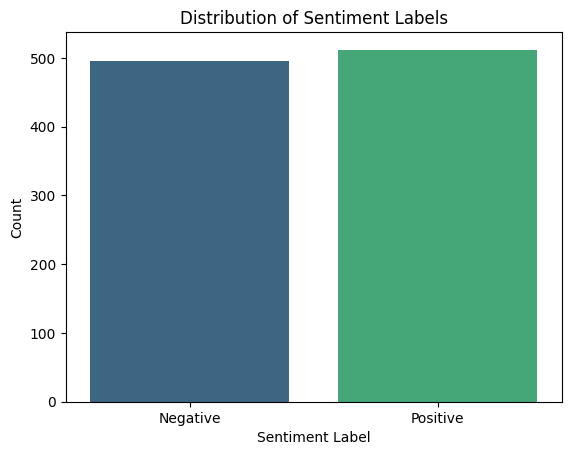

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
unsupervised_df = classify_and_label(df_augment)

print(unsupervised_df)
plot_label_distribution(unsupervised_df)

unsupervised_df.to_csv('classified_reviews.csv', index=False)
files.download('classified_reviews.csv')

In [26]:
import numpy as np
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

most_frequent_label = unsupervised_df['predicted_label'].mode()[0]
unsupervised_df = unsupervised_df.fillna(most_frequent_label)

X_aug = np.array(df_augment['embedding'].tolist())
y_aug = unsupervised_df['predicted_label']

X_labeled = np.array(df_train['embedding'].tolist())
y_labeled = df_train['label']

X_train = np.vstack([X_labeled, X_aug])
y_train = np.concatenate([y_labeled, y_aug])

X_test = np.array(df_test['embedding'].tolist())
y_test = df_test['label']

param_grid = {
    'C': [0.1, 1, 10, 100,1000],
    'kernel': ['linear', 'poly', 'rbf', 'sigmoid'],
    'gamma': [1, 0.1, 0.01, 0.001, 0.0001]
}

grid_search = GridSearchCV(SVC(), param_grid, cv=5, scoring='accuracy')


grid_search.fit(X_train, y_train)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)

print(f"Best Parameters: {grid_search.best_params_}")
print(f"Accuracy: {accuracy}")
print(f"Classification Report:\n{report}")
print(f"Confusion Matrix:\n{conf_matrix}")


Best Parameters: {'C': 0.1, 'gamma': 1, 'kernel': 'linear'}
Accuracy: 0.8466666666666667
Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.85      0.85        78
           1       0.84      0.85      0.84        72

    accuracy                           0.85       150
   macro avg       0.85      0.85      0.85       150
weighted avg       0.85      0.85      0.85       150

Confusion Matrix:
[[66 12]
 [11 61]]


# Questions
## 1. Research semi-supervised problems and explain how to select a proportion of data
for manual labeling. Does the choice of data matter?*italicized text*

In semi-supervised learning, the challenge often lies in determining how much and which data should be manually labeled to maximize the effectiveness of the learning process. Here’s a structured approach to selecting a proportion of data for manual labeling:
1. Initial Labeling Strategy:

    Start with a small labeled dataset: Begin by labeling a small subset of your data manually. This subset should ideally be chosen to represent the broader dataset in terms of variability and complexity.

    Select diverse examples: Choose examples that cover various classes or patterns in your data. This diversity helps in building a robust initial model and understanding the data distribution.

2. Active Learning Techniques:

    Use active learning algorithms: These algorithms select the most informative instances for manual labeling. Examples include uncertainty sampling (choosing instances where the model is uncertain), query by committee (choosing instances where different models disagree), and expected model change (instances that are expected to change the model the most when labeled).

    Iterative labeling: After training on the initial labeled data, use the model to predict labels for the unlabeled data. Then, select the most informative instances from the unlabeled data for manual labeling based on the active learning strategy chosen.

3. Balancing Labeling Effort and Model Performance:

    Evaluate model performance: Periodically evaluate the model’s performance on a validation set or through cross-validation. This helps in assessing how well the model is learning with the current labeled data.

    Adjust labeling strategy: Depending on the model’s performance and resource constraints (like budget or time), adjust the proportion of data to be labeled manually. If the model is performing well with the current amount of labeled data, label fewer new instances; if performance is stagnant, label more.

Does the Choice of Data Matter?

Yes, the choice of data for manual labeling does matter significantly. Here are key considerations:

   Representativeness: Labeled data should be representative of the entire dataset to ensure the model learns a broad spectrum of patterns and variations present in the data.

  Complexity: Include both easy and difficult examples for labeling. Easy examples help in establishing clear boundaries between classes, while difficult examples challenge the model and aid in learning nuanced patterns.

  Domain knowledge: Incorporate domain knowledge to prioritize instances that are critical or have high impact on the model’s overall performance or on specific application needs.

  Diversity: Ensure diversity in the labeled data to cover edge cases, outliers, and different scenarios present in the dataset. This diversity improves the model’s generalization ability

## 2. For label propagation, how many data points did you label using your manually labeled data? Explain the trade-off between quality and quantity of your labeled data.

There were 150 data for training our self learning model.Quality vs. Quantity Trade-off: The trade-off between quality and quantity of labeled data is crucial:

  Quality: The accuracy and correctness of manually labeled data are paramount. Labeling fewer data points manually allows you to focus more on ensuring that these labels are accurate and reliable.
  Quantity: Propagation algorithms benefit from larger amounts of labeled data. Labeling more data points manually initially can increase the quantity of labeled data available for propagation, potentially improving the overall performance of the algorithm.

## 3. Research the limitations of label propagation methods. Can these limitations be overcome using a large language model (LLM)? If yes, explain how and why using LLMs is more effective for these tasks

Label propagation methods, such as those used in semi-supervised learning, face several limitations that can potentially be addressed using large language models (LLMs) like GPT-3.5. Let's discuss these limitations and how LLMs can potentially overcome them:
Limitations of Label Propagation Methods:

  - Dependency on Graph Structure: Label propagation methods typically rely on the graph structure defined by data points and their relationships. If the graph structure is not well-defined or noisy, it can affect the quality of propagated labels.

  - Sensitive to Initialization: Initial label assignments can significantly impact the final results of label propagation methods. Poor initialization may lead to incorrect labels being propagated throughout the graph.

  - Difficulty with High-Dimensional Data: Traditional label propagation methods may struggle with high-dimensional data due to the curse of dimensionality, where distances become less meaningful and the graph structure may not capture relevant relationships.

  - Limited by Explicit Features: Many label propagation algorithms rely on explicitly defined features or distances between data points, which may not always capture the full complexity of natural language or nuanced relationships in text.

Effectiveness of LLMs for Label Propagation:

Using LLMs for label propagation tasks can be more effective because:

  - Contextual Understanding: LLMs leverage contextual embeddings to understand the meaning and relationships between text segments, which is crucial for tasks involving unstructured or natural language data.

  - Generalization Capability: LLMs generalize from vast amounts of pre-training data, allowing them to capture intricate relationships that might not be apparent in a limited graph structure or feature space.

  - Reduced Dependency on Graph Structures: LLMs can potentially reduce the dependency on explicit graph structures by learning implicit relationships from textual contexts, thus overcoming the limitations associated with graph-based methods.

## 4. Research the history of language modeling, their evolution, and explain how they work. Discuss the advantages and limitations of language models, especially large language models (LLMs), in various tasks.

  1. Early Days to Statistical Models (1950s-2000s):
        Language modeling began with rule-based and statistical approaches like N-grams and Hidden Markov Models.
        These models improved by capturing more complex word dependencies.

  2. Neural Networks and Transformers (2010s):
        Neural network-based models like RNNs and LSTMs enhanced sequence modeling capabilities.
        Transformers, introduced in 2017, revolutionized language modeling with self-attention mechanisms.

How LLMs Work

  - Pre-training: LLMs like GPT are trained on large text datasets to learn language patterns through tasks like predicting the next word or filling in masked words.
  - Fine-tuning: They are then adapted to specific tasks with additional training on task-specific data, leveraging their learned language understanding.

Advantages

  - State-of-the-Art Performance: LLMs achieve exceptional results across various natural language tasks, often surpassing previous methods.
  - Versatility: They can be applied to diverse tasks with minimal task-specific data and tuning.
  - Contextual Understanding: LLMs capture complex word relationships, enabling coherent text generation and nuanced responses.

Limitations

  - Data Dependency: LLMs require large datasets for effective pre-training, raising concerns about data privacy and computational resources.
  - Computational Resources: Training and deploying LLMs is computationally intensive, limiting accessibility.
  - Bias and Ethical Concerns: They may perpetuate biases present in training data and struggle with common sense reasoning and real-world knowledge.

## 5. For each method (LLM/Label-Propagation), explain its advantages and disadvantages.

Large Language Models (LLMs)

Advantages:

  - Versatility: Can be fine-tuned for various tasks like text generation and translation.
  - Contextual Understanding: Excellent at understanding context in language.
  - Pre-trained Knowledge: Broad understanding due to training on large datasets.
  - Ease of Use: Ready for use after initial training.

Disadvantages:

  - Computational Resources: Requires significant CPU/GPU and memory resources.
  - Large Scale: Models are large and complex to deploy.
  - Data Dependency: Performance hinges on having sufficient labeled data.
  - Interpretability: Outputs can be hard to interpret due to model complexity.

Label Propagation Algorithms

Advantages:

  - Semi-supervised Learning: Efficiently uses both labeled and unlabeled data.
  - Robust to Noise: Handles noisy data well by smoothing labels.
  - Scalability: Scales well to large datasets and complex graphs.
  - Flexibility: Applicable beyond classification tasks (e.g., social networks).

Disadvantages:

  - Graph Quality: Performance depends on the quality of the graph structure.
  - Computational Complexity: Can be intensive with large datasets.
  - Parameter Sensitivity: Performance relies on careful tuning of parameters.
  - Interpretability: Results can be challenging to interpret, similar to other ML algorithms.

## 6. Certainly, you have worked with large language models (LLMs) since they were made public, and you might even be using one right now to help you with your assignment! How has your experience been while interacting with one of them? How do other LLMs differ from each other? Name some of these LLMs that you have worked with and share your opinion about them.

I have worked with chatGPT, phind, hugging face chat, chatgot, etc. From personal experience chatGPT was the best and most accurate LLM I have worked with however sometimes the provided code is not what I'm looking for. For huggingchat the most important thing for me is that it's not banned in iran and does not require VPN to connect. I can also change the model I'm talking to which is quite useful. I usually use metal-llama-3 which is similar to gpt4. The problem with Chatgot is that it is limited even for GPT-3.5 but you can use gpt4 for a limited amount of times.